# How deep are financial models?
<div style="text-align: right">(C) Nikolai Nowaczyk, Jörg Kienitz, Sarp Kaya Acar, Qian Liang 2019</div>

In this notebook, we apply deep learning techniques to financial derivative pricing models, namely the Black-Scholes model and the Heston model. But just how deep does a neural network have to be to adaequately capture the pricing function? We employ a [systematic technique to determine a good network topology](https://github.com/niknow/machine-learning-examples/blob/master/network_topology_selection/network_topology_selection.ipynb) and inspect the results. We find that both, the Black-Scholes and the Heston pricing function can be learned quite easily by a standard multilayer perceptron (MLP).

In [82]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, LSTM
import keras
import os
from ipywidgets import interact
import ipywidgets as wg
import json
import pickle
import unittest

from keras_grid import MLPGrid, LSTMGrid
from pricinglib import BlackScholesCallPrice, HestonCallPrice

%matplotlib notebook

In [83]:
data_folder = os.path.join(os.getcwd(), 'data')
picture_folder = 'pics'

export_figures = False
def export_figure(fig, filename, extension='.pdf'):
    if export_figures:
        fig.savefig(os.path.join(os.path.join(os.getcwd(), picture_folder), filename + extension))

# Models

## Black-Scholes Model

Let $(\Omega, \mathcal{F}, \mathbb{Q})$ be a probability space (where we think of $\mathbb{Q}$ as the risk-neutral measure). Then the Black-Scholes model assumes the following stochastic dynamics for the stock:
\begin{align}
dS_t = r S_t dt + \sigma S_t dW_t, \qquad S_0 = s_0
\end{align}
where
* $s_0$ is the initial value for the stock
* $r \in \mathbb{R}$ is a fixed *risk-free rate*, 
* $\sigma > 0$ is the *volatility*, 
and the process $W_t$ is a Brownian motion. 

In the Black-Scholes model, a European call option $C = C(T,K)$ with maturity $T>0$ and strike $K>0$ has market value 
\begin{align}
    C_t = \mathbb{E}_t[(S_T - K)^+] = S_t \Phi(d_1) - K \exp(-r (T-t)) \Phi(d_2),
\end{align}
where $\Phi$ denotes the cdf of the standard normal distribution and 
$$ d_1 := \frac{1}{\sqrt{T-t}} \Big( \log\Big( \frac{S_t}{K} \Big) + (r + \frac{\sigma^2}{2}) (t-T) \Big), \quad
d_2 := d_1 - \sigma \sqrt{T-t}$$

## Heston Model
The Heston model assumes the following stochastic dynamics:
\begin{align}
    dS_t &= rS_t dt + \sqrt{V_t}dW_t, \quad S_0 = s_0 \\
    dV_t &= \kappa(\theta - V_t) S_t dt + \xi \sqrt{V_t} dZ_t, && V_0 = v_0,
\end{align}
where
* $s_0$ is the initial value for the stock,
* $v_0$ is the initial value for the volatility,
* $r$ is the risk-free rate,
* $\kappa$ is the mean reversion rate of the volatility,
* $\xi$ is the volatility of the volatility
* $\rho$ is the assumed correlation between the Brownian motions $W_t$ and $Z_t$.

One typically assumes that the parameters are chosen such that the Feller condition holds: $2 \kappa \theta > \xi^2$.

The option price in a Heston model can be computed (for $t=0$) via 
\begin{align}
    C_0(T,K) = S_0 + \Pi_1 - e^{-rT} K \Pi_2,
\end{align}
where $\Pi_1$ and $\Pi_2$ are given as integrals over the characteristic function $\Psi = \Psi_{\ln(S_T)}$ of $\ln(S_T)$:
\begin{align}
    \Pi_1 &= \frac{1}{2} + \frac{1}{\pi}\int_0^{\infty}{\operatorname{Re}\Big( \frac{e^{-iw \ln(K)} \Psi(w-i)}{i w \Psi(-i)} \Big) dw} \\
    \Pi_2 &= \frac{1}{2} + \frac{1}{\pi} \int_0^{\infty}{\operatorname{Re}\Big( \frac{e^{-iw \ln(K)} \Psi(w)}{i w } \Big) dw}
\end{align}

# Generating the data set

When generating a training set for any neural network that learns a derivative pricing function of any financial model, one always has two choices:

* **Option A:** First generate realizations of the underlying and then price the derivative.
* **Option B:** Generate derivative prices directly using synthetic values of the underlying.

Option A has the advantage that the distribution of the derivative prices is more concentrated around realistic values. This means that the network will have more data to learn the derivative prices for typical values of the underlying, but less data for corner cases. Option B has the advantage that one can simply chose the ranges irrespective on how they might be distributed according to the underyling stochastic dynamics. 

For the Black-Scholes model, if we only consider $t=0$ pricing, it does not matter, which option we chose as the option prices only depend linearly on $S_0$. Thus, in the following, we consider $t=0$ pricing.

In [84]:
# parameter configuration
S0=100
T_max=1
maturity_grid = np.linspace(1/300, T_max, 300)
strike_grid = np.linspace(S0*0.8, S0*1.2, 400)
maturity_grid_, strike_grid_ = np.meshgrid(maturity_grid, strike_grid)
maturity_grid_ = maturity_grid_.ravel()
strike_grid_ = strike_grid_.ravel()

# heston model
v0 = 0.02
vLong = 0.04
kappa = 0.3
volvol = 0.4
rho = -0.6
q=0

# black scholes model
S = 100  # spot price
r = 0  # risk-free rate
sigma = np.sqrt(v0) # volatility

In [5]:
# generation of the data set
df = pd.DataFrame({'K': strike_grid_,
                   'T': maturity_grid_,
                   'C_BlackScholes': BlackScholesCallPrice(S0, r, sigma, maturity_grid_, strike_grid_, t=0)})
df['C_Heston'] = df.apply(lambda row: HestonCallPrice(S0, row['T'], row['K'], r, q, v0, vLong, kappa, sigma, rho), axis=1)

In [10]:
df.to_pickle(os.path.join(data_folder, 'df_prices.pkl')) # save dataset to file

In [11]:
df = pd.read_pickle(os.path.join(data_folder, 'df_prices.pkl')) # load dataset from file

## Visualizing the data set

<IPython.core.display.Javascript object>


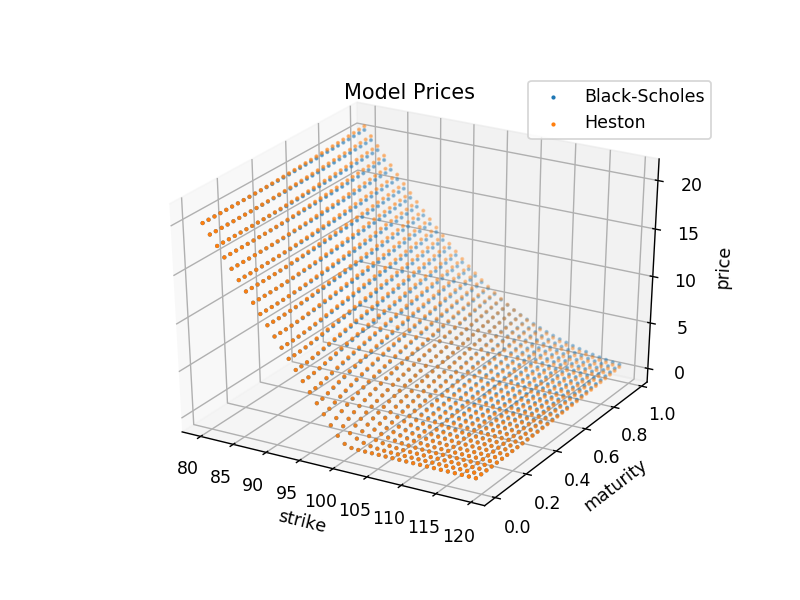

interactive(children=(SelectMultiple(description='Models', index=(0,), options=('BlackScholes', 'Heston'), val…

In [85]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# thinning out the df to avoid performance issues in the plot
df_3dplot = df[(df['T'].isin(maturity_grid[::10])) & (df['K'].isin(strike_grid[::10]))]


@interact(models=wg.SelectMultiple(
    options=['BlackScholes', 'Heston'],
    value=['BlackScholes'],
    description='Models',
))
def plot_dataset(models):
    ax.clear()
    if 'BlackScholes' in models:
        ax.scatter3D(df_3dplot['K'], df_3dplot['T'], df_3dplot['C_BlackScholes'], s=2, label='Black-Scholes')
    if 'Heston' in models:
        ax.scatter3D(df_3dplot['K'], df_3dplot['T'], df_3dplot['C_Heston'], s=2, label='Heston')
    ax.legend()
    ax.set_xlabel('strike')
    ax.set_ylabel('maturity')
    ax.set_zlabel('price')
    ax.set_title('Model Prices')
    export_figure(fig, 'model_prices_' + '_'.join(models))

We conclude that while the equations of the stochastic dynamics differ between the Black-Scholes and the Heston model, the resulting training sets are quite similar when viewed as data sets.

# Network Topology Selection

We define a 2D grid of Multilayer Perceptrons (MLPs) as candidate networks to learn the Black-Scholes and Heston pricing formula. The first dimension is the number of neurons in each layer, whereas the second dimension is the number of layers. When increasing the number of layers, we chose to decrease the number of neurons such that the resulting number of weights stays roughly constant. The rationale behind this is that we want to find a good network topology given a number of degrees of freedom. More details on this reasoning can be found [here](https://github.com/niknow/machine-learning-examples/blob/master/network_topology_selection/network_topology_selection.ipynb).
We also set up a comparable grid of LSTM networks and compare which of the two topologies is more suitable to learn the pricing function.

## Setting up the candidate models

In [86]:
pricing_models = ['BlackScholes', 'Heston']
pricing_model = pricing_models[1]  # change to 1 for Heston

In [87]:
# setup MLPs
n_o = 1
n_i = 2
range_units = np.array([2**i for i in range(6, 12)])
range_layers = np.array(list(range(2,6)))

mlpg = MLPGrid(num_inputs=n_i,
               num_outputs=n_o,
               range_units=range_units,
               range_layers=range_layers,
               constant_num_weights=True)
mlpg.initialize()

# setup LSTMs such that number of weights is comparable
range_units = np.array([LSTMGrid.num_units(n_i-1, n_o, n_L=range_layers[0], 
                                           n_w=MLPGrid.num_weights(n_i, n_o, n_L=range_layers[0], 
                                                                   n_u=mlpg.range_units[unit_idx]))
                       for unit_idx in range(len(mlpg.range_units))])

lstmg = LSTMGrid(num_inputs=n_i-1, 
                num_outputs=n_o, 
                range_units=range_units,
                range_layers=range_layers,
                num_time_steps=maturity_grid.shape[0],
                constant_num_weights=True)
lstmg.initialize()

<IPython.core.display.Javascript object>


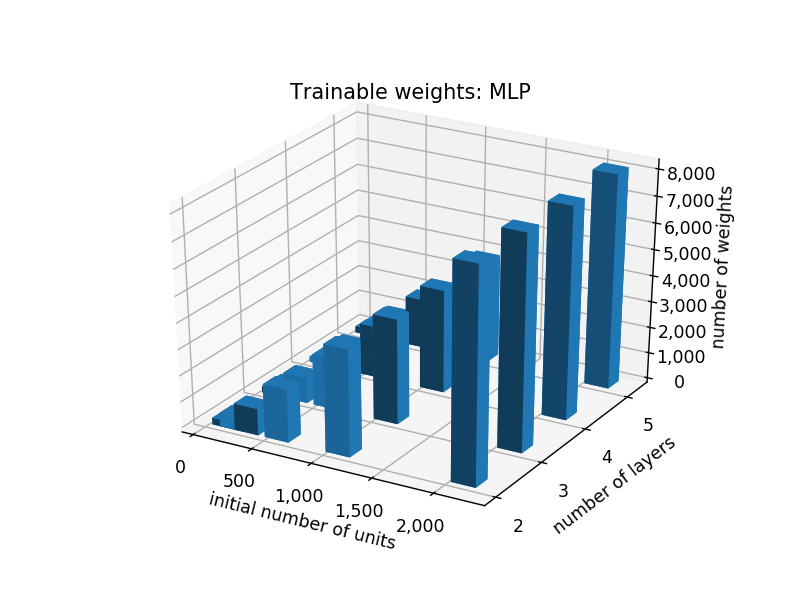

interactive(children=(RadioButtons(description='Network Type:', options=('MLP', 'LSTM'), value='MLP'), Output(…

In [88]:
# plot number of weights
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

@interact(network_type=wg.RadioButtons(options=['MLP', 'LSTM'],
                                       value='MLP',
                                       description='Network Type:'))
def plot_num_weights(network_type):
    if network_type=='MLP':
        mgrid=mlpg
        xx, yy = np.meshgrid(mlpg.range_units, mlpg.range_layers)
        width = 200
    else:
        mgrid=lstmg
        xx, yy = np.meshgrid(lstmg.range_units, lstmg.range_layers)
        width = 3
    x, y = xx.ravel(), yy.ravel()
    z = np.array([[mgrid.models[u][l].count_params() for u in range(len(range_units))] for l in range(len(range_layers))]).ravel()
    bottom = np.zeros_like(z)    
    depth = 0.25
    ax.clear()
    ax.bar3d(x, y, bottom, width, depth, z, shade=True)
    ax.set_title('Trainable weights: %s' % network_type)
    ax.set_xlabel('initial number of units')
    ax.set_ylabel('number of layers')
    ax.set_zlabel('number of weights')
    ax.set_yticks(range_layers)
    ax.zaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x))))
    export_figure(fig, 'trainable_weights_' + network_type)

When comparing the number of units between MLP and LSTM, we find that the number of units in the LSTM that generates the same number of weights than the MLP is quite low. That is because a layer in an LSTM has much more complexity than in an MLP, recall the introduction to LSTMs [here](https://nbviewer.jupyter.org/github/niknow/machine-learning-examples/blob/master/lstm_intro/lstm_intro.ipynb). This means that we would expect the LSTM to perform better in situations where this additional complexity is needed to solve the problem the network is trying to learn and to perform worse in cases where it is not needed, because then the MLP has much more units available per layer.

## Training the networks

In [89]:
compile_params = {
    'loss': 'mean_squared_error',
    'metrics': ['mean_squared_error', 'mean_absolute_error'],
    'optimizer': 'Adam',
}
mlpg.compile(**compile_params)
lstmg.compile(**compile_params)

In [90]:
fit_params={
    'validation_split': 0.2,
    'epochs': 200,
    'shuffle': True}

In [41]:
%time
mlpg.fit(x=df[['K', 'T']], y=df['C_'+pricing_model],**fit_params)
print("Training complete.")

Wall time: 0 ns
------------------------------
Fitting with units_index=0 and layers_index=0
------------------------------
Train on 96000 samples, validate on 24000 samples
Epoch 1/200
96000/96000 [==============================] - 26s 274us/step - loss: 29.6701 - mean_squared_error: 29.6701 - mean_absolute_error: 4.6810 - val_loss: 23.3941 - val_mean_squared_error: 23.3941 - val_mean_absolute_error: 4.7355
Epoch 2/200
96000/96000 [==============================] - 11s 118us/step - loss: 11.3354 - mean_squared_error: 11.3354 - mean_absolute_error: 2.7811 - val_loss: 0.6601 - val_mean_squared_error: 0.6601 - val_mean_absolute_error: 0.6719
Epoch 3/200
96000/96000 [==============================] - 11s 112us/step - loss: 1.7335 - mean_squared_error: 1.7335 - mean_absolute_error: 1.0275 - val_loss: 9.5129 - val_mean_squared_error: 9.5129 - val_mean_absolute_error: 2.9871
Epoch 4/200
96000/96000 [==============================] - 10s 107us/step - loss: 0.8007 - mean_squared_error: 0.8007 

Epoch 69/200
96000/96000 [==============================] - 10s 99us/step - loss: 0.1318 - mean_squared_error: 0.1318 - mean_absolute_error: 0.2598 - val_loss: 1.8332 - val_mean_squared_error: 1.8332 - val_mean_absolute_error: 1.2232
Epoch 70/200
96000/96000 [==============================] - 10s 105us/step - loss: 0.1309 - mean_squared_error: 0.1309 - mean_absolute_error: 0.2585 - val_loss: 1.7348 - val_mean_squared_error: 1.7348 - val_mean_absolute_error: 1.1807
Epoch 71/200
96000/96000 [==============================] - 10s 100us/step - loss: 0.1306 - mean_squared_error: 0.1306 - mean_absolute_error: 0.2582 - val_loss: 1.5035 - val_mean_squared_error: 1.5035 - val_mean_absolute_error: 1.0888: 0.1313 - me - ETA: 1s - loss: 0.1313 - me - ETA: 0s - loss: 0.1304 - mean_squared_error: 0.1304 - mean_absolute_e
Epoch 72/200
96000/96000 [==============================] - 10s 99us/step - loss: 0.1305 - mean_squared_error: 0.1305 - mean_absolute_error: 0.2580 - val_loss: 1.5715 - val_mean_squ

Epoch 103/200
96000/96000 [==============================] - 9s 98us/step - loss: 0.1110 - mean_squared_error: 0.1110 - mean_absolute_error: 0.2322 - val_loss: 1.3562 - val_mean_squared_error: 1.3562 - val_mean_absolute_error: 1.0455
Epoch 104/200
96000/96000 [==============================] - 10s 99us/step - loss: 0.1104 - mean_squared_error: 0.1104 - mean_absolute_error: 0.2314 - val_loss: 1.1627 - val_mean_squared_error: 1.1627 - val_mean_absolute_error: 0.9363
Epoch 105/200
96000/96000 [==============================] - 9s 98us/step - loss: 0.1106 - mean_squared_error: 0.1106 - mean_absolute_error: 0.2320 - val_loss: 1.4027 - val_mean_squared_error: 1.4027 - val_mean_absolute_error: 1.0747
Epoch 106/200
96000/96000 [==============================] - 9s 98us/step - loss: 0.1084 - mean_squared_error: 0.1084 - mean_absolute_error: 0.2284 - val_loss: 1.2181 - val_mean_squared_error: 1.2181 - val_mean_absolute_error: 0.9814
Epoch 107/200
96000/96000 [==============================] - 9s

96000/96000 [==============================] - 9s 98us/step - loss: 0.0638 - mean_squared_error: 0.0638 - mean_absolute_error: 0.1658 - val_loss: 0.4858 - val_mean_squared_error: 0.4858 - val_mean_absolute_error: 0.5467
Epoch 171/200
96000/96000 [==============================] - 9s 98us/step - loss: 0.0614 - mean_squared_error: 0.0614 - mean_absolute_error: 0.1614 - val_loss: 0.5431 - val_mean_squared_error: 0.5431 - val_mean_absolute_error: 0.5861
Epoch 172/200
96000/96000 [==============================] - 9s 98us/step - loss: 0.0599 - mean_squared_error: 0.0599 - mean_absolute_error: 0.1603 - val_loss: 0.3922 - val_mean_squared_error: 0.3922 - val_mean_absolute_error: 0.4617
Epoch 173/200
96000/96000 [==============================] - 10s 100us/step - loss: 0.0583 - mean_squared_error: 0.0583 - mean_absolute_error: 0.1579 - val_loss: 0.4072 - val_mean_squared_error: 0.4072 - val_mean_absolute_error: 0.4887
Epoch 174/200
96000/96000 [==============================] - 9s 98us/step - 

96000/96000 [==============================] - 10s 108us/step - loss: 0.0520 - mean_squared_error: 0.0520 - mean_absolute_error: 0.1544 - val_loss: 0.6220 - val_mean_squared_error: 0.6220 - val_mean_absolute_error: 0.6395
Epoch 39/200
96000/96000 [==============================] - 10s 108us/step - loss: 0.0515 - mean_squared_error: 0.0515 - mean_absolute_error: 0.1546 - val_loss: 0.3953 - val_mean_squared_error: 0.3953 - val_mean_absolute_error: 0.4795
Epoch 40/200
96000/96000 [==============================] - 10s 108us/step - loss: 0.0493 - mean_squared_error: 0.0493 - mean_absolute_error: 0.1506 - val_loss: 0.4756 - val_mean_squared_error: 0.4756 - val_mean_absolute_error: 0.5319
Epoch 41/200
96000/96000 [==============================] - 10s 109us/step - loss: 0.0480 - mean_squared_error: 0.0480 - mean_absolute_error: 0.1483 - val_loss: 0.4652 - val_mean_squared_error: 0.4652 - val_mean_absolute_error: 0.5406
Epoch 42/200
96000/96000 [==============================] - 10s 108us/ste

Epoch 107/200
96000/96000 [==============================] - 11s 110us/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0387 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.0974
Epoch 108/200
96000/96000 [==============================] - 11s 109us/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0369 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1047
Epoch 109/200
96000/96000 [==============================] - 11s 110us/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0377 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1090
Epoch 110/200
96000/96000 [==============================] - 11s 110us/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0371 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.0895
Epoch 111/200
96000/96000 [=============================

96000/96000 [==============================] - 11s 110us/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0344 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0682
Epoch 176/200
96000/96000 [==============================] - 11s 110us/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0329 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0701
Epoch 177/200
96000/96000 [==============================] - 11s 110us/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0325 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0751
Epoch 178/200
96000/96000 [==============================] - 11s 110us/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0329 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0689
Epoch 179/200
96000/96000 [==============================] - 11s 110us

96000/96000 [==============================] - 11s 116us/step - loss: 37.2917 - mean_squared_error: 37.2917 - mean_absolute_error: 5.3138 - val_loss: 56.2344 - val_mean_squared_error: 56.2344 - val_mean_absolute_error: 7.4919
Epoch 10/200
96000/96000 [==============================] - 11s 117us/step - loss: 37.2891 - mean_squared_error: 37.2891 - mean_absolute_error: 5.3133 - val_loss: 58.1046 - val_mean_squared_error: 58.1046 - val_mean_absolute_error: 7.6157
Epoch 11/200
96000/96000 [==============================] - 11s 117us/step - loss: 37.2929 - mean_squared_error: 37.2929 - mean_absolute_error: 5.3151 - val_loss: 56.6568 - val_mean_squared_error: 56.6568 - val_mean_absolute_error: 7.5201
Epoch 12/200
96000/96000 [==============================] - 11s 117us/step - loss: 37.2906 - mean_squared_error: 37.2906 - mean_absolute_error: 5.3148 - val_loss: 55.2803 - val_mean_squared_error: 55.2803 - val_mean_absolute_error: 7.4280
Epoch 13/200
96000/96000 [==============================]

96000/96000 [==============================] - 11s 116us/step - loss: 37.2913 - mean_squared_error: 37.2913 - mean_absolute_error: 5.3138 - val_loss: 56.1165 - val_mean_squared_error: 56.1165 - val_mean_absolute_error: 7.4841
Epoch 78/200
96000/96000 [==============================] - 11s 116us/step - loss: 37.2903 - mean_squared_error: 37.2903 - mean_absolute_error: 5.3141 - val_loss: 56.3257 - val_mean_squared_error: 56.3257 - val_mean_absolute_error: 7.4980
Epoch 79/200
96000/96000 [==============================] - 11s 116us/step - loss: 37.2904 - mean_squared_error: 37.2904 - mean_absolute_error: 5.3146 - val_loss: 55.1141 - val_mean_squared_error: 55.1141 - val_mean_absolute_error: 7.4168
Epoch 80/200
96000/96000 [==============================] - 11s 116us/step - loss: 37.2919 - mean_squared_error: 37.2919 - mean_absolute_error: 5.3140 - val_loss: 55.4243 - val_mean_squared_error: 55.4243 - val_mean_absolute_error: 7.4377
Epoch 81/200
96000/96000 [==============================]

96000/96000 [==============================] - 11s 117us/step - loss: 37.2907 - mean_squared_error: 37.2907 - mean_absolute_error: 5.3139 - val_loss: 55.3659 - val_mean_squared_error: 55.3659 - val_mean_absolute_error: 7.4337
Epoch 146/200
96000/96000 [==============================] - 11s 117us/step - loss: 37.2906 - mean_squared_error: 37.2906 - mean_absolute_error: 5.3137 - val_loss: 56.0019 - val_mean_squared_error: 56.0019 - val_mean_absolute_error: 7.4764
Epoch 147/200
96000/96000 [==============================] - 11s 117us/step - loss: 37.2915 - mean_squared_error: 37.2915 - mean_absolute_error: 5.3139 - val_loss: 57.1008 - val_mean_squared_error: 57.1008 - val_mean_absolute_error: 7.5495
Epoch 148/200
96000/96000 [==============================] - 11s 117us/step - loss: 37.2916 - mean_squared_error: 37.2916 - mean_absolute_error: 5.3146 - val_loss: 56.2121 - val_mean_squared_error: 56.2121 - val_mean_absolute_error: 7.4904
Epoch 149/200
96000/96000 [===========================

96000/96000 [==============================] - 12s 122us/step - loss: 37.2937 - mean_squared_error: 37.2937 - mean_absolute_error: 5.3141 - val_loss: 55.0615 - val_mean_squared_error: 55.0615 - val_mean_absolute_error: 7.4132
Epoch 13/200
96000/96000 [==============================] - 12s 122us/step - loss: 37.2921 - mean_squared_error: 37.2921 - mean_absolute_error: 5.3137 - val_loss: 56.6944 - val_mean_squared_error: 56.6944 - val_mean_absolute_error: 7.5226
Epoch 14/200
96000/96000 [==============================] - 12s 122us/step - loss: 37.2906 - mean_squared_error: 37.2906 - mean_absolute_error: 5.3141 - val_loss: 56.2487 - val_mean_squared_error: 56.2487 - val_mean_absolute_error: 7.4929
Epoch 15/200
96000/96000 [==============================] - 12s 122us/step - loss: 37.2919 - mean_squared_error: 37.2919 - mean_absolute_error: 5.3146 - val_loss: 54.9041 - val_mean_squared_error: 54.9041 - val_mean_absolute_error: 7.4026
Epoch 16/200
96000/96000 [==============================]

96000/96000 [==============================] - 12s 121us/step - loss: 37.2924 - mean_squared_error: 37.2924 - mean_absolute_error: 5.3146 - val_loss: 55.6289 - val_mean_squared_error: 55.6289 - val_mean_absolute_error: 7.4514
Epoch 81/200
96000/96000 [==============================] - 12s 122us/step - loss: 37.2928 - mean_squared_error: 37.2928 - mean_absolute_error: 5.3137 - val_loss: 56.6393 - val_mean_squared_error: 56.6393 - val_mean_absolute_error: 7.5189
Epoch 82/200
96000/96000 [==============================] - 12s 122us/step - loss: 37.2922 - mean_squared_error: 37.2922 - mean_absolute_error: 5.3145 - val_loss: 55.7079 - val_mean_squared_error: 55.7079 - val_mean_absolute_error: 7.4567
Epoch 83/200
96000/96000 [==============================] - 12s 121us/step - loss: 37.2923 - mean_squared_error: 37.2923 - mean_absolute_error: 5.3140 - val_loss: 55.7384 - val_mean_squared_error: 55.7384 - val_mean_absolute_error: 7.4587
Epoch 84/200
96000/96000 [==============================]

96000/96000 [==============================] - 12s 122us/step - loss: 37.2898 - mean_squared_error: 37.2898 - mean_absolute_error: 5.3139 - val_loss: 54.6111 - val_mean_squared_error: 54.6111 - val_mean_absolute_error: 7.3828
Epoch 149/200
96000/96000 [==============================] - 12s 122us/step - loss: 37.2917 - mean_squared_error: 37.2917 - mean_absolute_error: 5.3136 - val_loss: 55.7939 - val_mean_squared_error: 55.7939 - val_mean_absolute_error: 7.4625
Epoch 150/200
96000/96000 [==============================] - 12s 122us/step - loss: 37.2923 - mean_squared_error: 37.2923 - mean_absolute_error: 5.3141 - val_loss: 55.8423 - val_mean_squared_error: 55.8423 - val_mean_absolute_error: 7.4657
Epoch 151/200
96000/96000 [==============================] - 12s 121us/step - loss: 37.2924 - mean_squared_error: 37.2924 - mean_absolute_error: 5.3145 - val_loss: 55.5577 - val_mean_squared_error: 55.5577 - val_mean_absolute_error: 7.4466
Epoch 152/200
96000/96000 [===========================

96000/96000 [==============================] - 10s 101us/step - loss: 0.2077 - mean_squared_error: 0.2077 - mean_absolute_error: 0.3325 - val_loss: 3.2844 - val_mean_squared_error: 3.2844 - val_mean_absolute_error: 1.6067
Epoch 16/200
96000/96000 [==============================] - 10s 101us/step - loss: 0.2043 - mean_squared_error: 0.2043 - mean_absolute_error: 0.3303 - val_loss: 3.3599 - val_mean_squared_error: 3.3599 - val_mean_absolute_error: 1.6158
Epoch 17/200
96000/96000 [==============================] - 10s 101us/step - loss: 0.2047 - mean_squared_error: 0.2047 - mean_absolute_error: 0.3323 - val_loss: 3.0300 - val_mean_squared_error: 3.0300 - val_mean_absolute_error: 1.4949
Epoch 18/200
96000/96000 [==============================] - 10s 101us/step - loss: 0.2000 - mean_squared_error: 0.2000 - mean_absolute_error: 0.3285 - val_loss: 2.5901 - val_mean_squared_error: 2.5901 - val_mean_absolute_error: 1.3918
Epoch 19/200
96000/96000 [==============================] - 10s 102us/ste

96000/96000 [==============================] - 10s 101us/step - loss: 0.1603 - mean_squared_error: 0.1603 - mean_absolute_error: 0.2944 - val_loss: 1.9638 - val_mean_squared_error: 1.9638 - val_mean_absolute_error: 1.2545
Epoch 84/200
96000/96000 [==============================] - 10s 101us/step - loss: 0.1568 - mean_squared_error: 0.1568 - mean_absolute_error: 0.2910 - val_loss: 2.3144 - val_mean_squared_error: 2.3144 - val_mean_absolute_error: 1.3628
Epoch 85/200
96000/96000 [==============================] - 10s 101us/step - loss: 0.1573 - mean_squared_error: 0.1573 - mean_absolute_error: 0.2915 - val_loss: 2.3128 - val_mean_squared_error: 2.3128 - val_mean_absolute_error: 1.3868
Epoch 86/200
96000/96000 [==============================] - 10s 101us/step - loss: 0.1582 - mean_squared_error: 0.1582 - mean_absolute_error: 0.2923 - val_loss: 1.9222 - val_mean_squared_error: 1.9222 - val_mean_absolute_error: 1.2562
Epoch 87/200
96000/96000 [==============================] - 10s 101us/ste

96000/96000 [==============================] - 10s 101us/step - loss: 0.1235 - mean_squared_error: 0.1235 - mean_absolute_error: 0.2497 - val_loss: 1.7764 - val_mean_squared_error: 1.7764 - val_mean_absolute_error: 1.1683
Epoch 152/200
96000/96000 [==============================] - 10s 101us/step - loss: 0.1212 - mean_squared_error: 0.1212 - mean_absolute_error: 0.2455 - val_loss: 1.6230 - val_mean_squared_error: 1.6230 - val_mean_absolute_error: 1.1306
Epoch 153/200
96000/96000 [==============================] - 10s 101us/step - loss: 0.1211 - mean_squared_error: 0.1211 - mean_absolute_error: 0.2459 - val_loss: 1.4187 - val_mean_squared_error: 1.4187 - val_mean_absolute_error: 1.0725
Epoch 154/200
96000/96000 [==============================] - 10s 102us/step - loss: 0.1200 - mean_squared_error: 0.1200 - mean_absolute_error: 0.2443 - val_loss: 1.5318 - val_mean_squared_error: 1.5318 - val_mean_absolute_error: 1.0794
Epoch 155/200
96000/96000 [==============================] - 10s 101us

96000/96000 [==============================] - 11s 112us/step - loss: 0.0667 - mean_squared_error: 0.0667 - mean_absolute_error: 0.1732 - val_loss: 0.6916 - val_mean_squared_error: 0.6916 - val_mean_absolute_error: 0.6687
Epoch 20/200
96000/96000 [==============================] - 11s 113us/step - loss: 0.0639 - mean_squared_error: 0.0639 - mean_absolute_error: 0.1691 - val_loss: 0.6679 - val_mean_squared_error: 0.6679 - val_mean_absolute_error: 0.6502
Epoch 21/200
96000/96000 [==============================] - 11s 112us/step - loss: 0.0639 - mean_squared_error: 0.0639 - mean_absolute_error: 0.1708 - val_loss: 0.6745 - val_mean_squared_error: 0.6745 - val_mean_absolute_error: 0.6769
Epoch 22/200
96000/96000 [==============================] - 11s 113us/step - loss: 0.0621 - mean_squared_error: 0.0621 - mean_absolute_error: 0.1687 - val_loss: 0.5622 - val_mean_squared_error: 0.5622 - val_mean_absolute_error: 0.5816
Epoch 23/200
96000/96000 [==============================] - 11s 113us/ste

Epoch 54/200
96000/96000 [==============================] - 11s 112us/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0639 - val_loss: 0.1350 - val_mean_squared_error: 0.1350 - val_mean_absolute_error: 0.3277
Epoch 55/200
96000/96000 [==============================] - 11s 112us/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0644 - val_loss: 0.1070 - val_mean_squared_error: 0.1070 - val_mean_absolute_error: 0.2855
Epoch 56/200
96000/96000 [==============================] - 11s 112us/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0636 - val_loss: 0.1074 - val_mean_squared_error: 0.1074 - val_mean_absolute_error: 0.2809
Epoch 57/200
96000/96000 [==============================] - 11s 112us/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0649 - val_loss: 0.1434 - val_mean_squared_error: 0.1434 - val_mean_absolute_error: 0.3397
Epoch 58/200
96000/96000 [==============================] - 

96000/96000 [==============================] - 11s 112us/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0405 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1256
Epoch 123/200
96000/96000 [==============================] - 11s 114us/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0413 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1147
Epoch 124/200
96000/96000 [==============================] - 11s 113us/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0442 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1096
Epoch 125/200
96000/96000 [==============================] - 11s 112us/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0396 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1143
Epoch 126/200
96000/96000 [==============================] - 11s 112us

Epoch 191/200
96000/96000 [==============================] - 11s 112us/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0344 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0409
Epoch 192/200
96000/96000 [==============================] - 11s 112us/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0357 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0423
Epoch 193/200
96000/96000 [==============================] - 11s 112us/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0355 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0421
Epoch 194/200
96000/96000 [==============================] - 11s 112us/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0350 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0510
Epoch 195/200
96000/96000 [=============================

Epoch 59/200
96000/96000 [==============================] - 11s 118us/step - loss: 0.0426 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1474 - val_loss: 0.1739 - val_mean_squared_error: 0.1739 - val_mean_absolute_error: 0.3399
Epoch 60/200
96000/96000 [==============================] - 11s 118us/step - loss: 0.0393 - mean_squared_error: 0.0393 - mean_absolute_error: 0.1393 - val_loss: 0.1864 - val_mean_squared_error: 0.1864 - val_mean_absolute_error: 0.3556
Epoch 61/200
96000/96000 [==============================] - 11s 118us/step - loss: 0.0394 - mean_squared_error: 0.0394 - mean_absolute_error: 0.1398 - val_loss: 0.1651 - val_mean_squared_error: 0.1651 - val_mean_absolute_error: 0.3247
Epoch 62/200
96000/96000 [==============================] - 11s 118us/step - loss: 0.0374 - mean_squared_error: 0.0374 - mean_absolute_error: 0.1364 - val_loss: 0.1721 - val_mean_squared_error: 0.1721 - val_mean_absolute_error: 0.3364
Epoch 63/200
96000/96000 [==============================] - 

96000/96000 [==============================] - 11s 118us/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0687 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0761
Epoch 128/200
96000/96000 [==============================] - 11s 118us/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0685 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0797
Epoch 129/200
96000/96000 [==============================] - 11s 118us/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0692 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0747
Epoch 130/200
96000/96000 [==============================] - 11s 118us/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0682 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0931
Epoch 131/200
96000/96000 [==============================] - 11s 118us

96000/96000 [==============================] - 11s 118us/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0506 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0529
Epoch 196/200
96000/96000 [==============================] - 11s 118us/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0542 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0486
Epoch 197/200
96000/96000 [==============================] - 11s 118us/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0496 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0571
Epoch 198/200
96000/96000 [==============================] - 11s 118us/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0506 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0469
Epoch 199/200
96000/96000 [==============================] - 11s 118us

Epoch 62/200
96000/96000 [==============================] - 12s 124us/step - loss: 37.2908 - mean_squared_error: 37.2908 - mean_absolute_error: 5.3131 - val_loss: 58.8537 - val_mean_squared_error: 58.8537 - val_mean_absolute_error: 7.6647
Epoch 63/200
96000/96000 [==============================] - 12s 124us/step - loss: 37.2919 - mean_squared_error: 37.2919 - mean_absolute_error: 5.3145 - val_loss: 57.1358 - val_mean_squared_error: 57.1358 - val_mean_absolute_error: 7.5518
Epoch 64/200
96000/96000 [==============================] - 12s 124us/step - loss: 37.2928 - mean_squared_error: 37.2928 - mean_absolute_error: 5.3147 - val_loss: 55.7693 - val_mean_squared_error: 55.7693 - val_mean_absolute_error: 7.4608
Epoch 65/200
96000/96000 [==============================] - 12s 124us/step - loss: 37.2911 - mean_squared_error: 37.2911 - mean_absolute_error: 5.3136 - val_loss: 57.1345 - val_mean_squared_error: 57.1345 - val_mean_absolute_error: 7.5518
Epoch 66/200
96000/96000 [==================

96000/96000 [==============================] - 12s 126us/step - loss: 37.2900 - mean_squared_error: 37.2900 - mean_absolute_error: 5.3140 - val_loss: 56.3252 - val_mean_squared_error: 56.3252 - val_mean_absolute_error: 7.4980
Epoch 131/200
96000/96000 [==============================] - 12s 125us/step - loss: 37.2924 - mean_squared_error: 37.2924 - mean_absolute_error: 5.3147 - val_loss: 54.5702 - val_mean_squared_error: 54.5702 - val_mean_absolute_error: 7.3800
Epoch 132/200
96000/96000 [==============================] - 12s 125us/step - loss: 37.2927 - mean_squared_error: 37.2927 - mean_absolute_error: 5.3141 - val_loss: 55.2205 - val_mean_squared_error: 55.2205 - val_mean_absolute_error: 7.4240
Epoch 133/200
96000/96000 [==============================] - 12s 125us/step - loss: 37.2922 - mean_squared_error: 37.2922 - mean_absolute_error: 5.3143 - val_loss: 54.9449 - val_mean_squared_error: 54.9449 - val_mean_absolute_error: 7.4054
Epoch 134/200
96000/96000 [===========================

96000/96000 [==============================] - 12s 125us/step - loss: 37.2898 - mean_squared_error: 37.2898 - mean_absolute_error: 5.3137 - val_loss: 57.0781 - val_mean_squared_error: 57.0781 - val_mean_absolute_error: 7.5480
Epoch 199/200
96000/96000 [==============================] - 12s 125us/step - loss: 37.2910 - mean_squared_error: 37.2910 - mean_absolute_error: 5.3148 - val_loss: 55.5170 - val_mean_squared_error: 55.5170 - val_mean_absolute_error: 7.4439
Epoch 200/200
96000/96000 [==============================] - 12s 126us/step - loss: 37.2930 - mean_squared_error: 37.2930 - mean_absolute_error: 5.3141 - val_loss: 56.2888 - val_mean_squared_error: 56.2888 - val_mean_absolute_error: 7.4956
DONE


------------------------------
Fitting with units_index=2 and layers_index=0
------------------------------
Train on 96000 samples, validate on 24000 samples
Epoch 1/200
96000/96000 [==============================] - 22s 231us/step - loss: 14.4803 - mean_squared_error: 14.4803 - mean_ab

96000/96000 [==============================] - 10s 106us/step - loss: 0.1845 - mean_squared_error: 0.1845 - mean_absolute_error: 0.3214 - val_loss: 2.9920 - val_mean_squared_error: 2.9920 - val_mean_absolute_error: 1.5704
Epoch 67/200
96000/96000 [==============================] - 10s 106us/step - loss: 0.1865 - mean_squared_error: 0.1865 - mean_absolute_error: 0.3226 - val_loss: 2.4927 - val_mean_squared_error: 2.4927 - val_mean_absolute_error: 1.4276
Epoch 68/200
96000/96000 [==============================] - 10s 106us/step - loss: 0.1845 - mean_squared_error: 0.1845 - mean_absolute_error: 0.3209 - val_loss: 2.2594 - val_mean_squared_error: 2.2594 - val_mean_absolute_error: 1.3280
Epoch 69/200
96000/96000 [==============================] - 10s 106us/step - loss: 0.1852 - mean_squared_error: 0.1852 - mean_absolute_error: 0.3216 - val_loss: 2.2368 - val_mean_squared_error: 2.2368 - val_mean_absolute_error: 1.3325
Epoch 70/200
96000/96000 [==============================] - 10s 106us/ste

Epoch 101/200
96000/96000 [==============================] - 10s 107us/step - loss: 0.1740 - mean_squared_error: 0.1740 - mean_absolute_error: 0.3104 - val_loss: 2.2745 - val_mean_squared_error: 2.2745 - val_mean_absolute_error: 1.3833
Epoch 102/200
96000/96000 [==============================] - 10s 106us/step - loss: 0.1735 - mean_squared_error: 0.1735 - mean_absolute_error: 0.3098 - val_loss: 2.1505 - val_mean_squared_error: 2.1505 - val_mean_absolute_error: 1.3305
Epoch 103/200
96000/96000 [==============================] - 10s 106us/step - loss: 0.1708 - mean_squared_error: 0.1708 - mean_absolute_error: 0.3072 - val_loss: 2.1202 - val_mean_squared_error: 2.1202 - val_mean_absolute_error: 1.2970
Epoch 104/200
96000/96000 [==============================] - 10s 106us/step - loss: 0.1741 - mean_squared_error: 0.1741 - mean_absolute_error: 0.3106 - val_loss: 1.7055 - val_mean_squared_error: 1.7055 - val_mean_absolute_error: 1.1444
Epoch 105/200
96000/96000 [=============================

Epoch 136/200
96000/96000 [==============================] - 10s 106us/step - loss: 0.1606 - mean_squared_error: 0.1606 - mean_absolute_error: 0.2955 - val_loss: 2.0981 - val_mean_squared_error: 2.0981 - val_mean_absolute_error: 1.3051
Epoch 137/200
96000/96000 [==============================] - 10s 106us/step - loss: 0.1583 - mean_squared_error: 0.1583 - mean_absolute_error: 0.2929 - val_loss: 1.9364 - val_mean_squared_error: 1.9364 - val_mean_absolute_error: 1.2387
Epoch 138/200
96000/96000 [==============================] - 10s 106us/step - loss: 0.1604 - mean_squared_error: 0.1604 - mean_absolute_error: 0.2949 - val_loss: 1.7102 - val_mean_squared_error: 1.7102 - val_mean_absolute_error: 1.1681
Epoch 139/200
96000/96000 [==============================] - 10s 106us/step - loss: 0.1596 - mean_squared_error: 0.1596 - mean_absolute_error: 0.2942 - val_loss: 2.2098 - val_mean_squared_error: 2.2098 - val_mean_absolute_error: 1.3562
Epoch 140/200
96000/96000 [=============================

96000/96000 [==============================] - 11s 110us/step - loss: 37.2989 - mean_squared_error: 37.2989 - mean_absolute_error: 5.3144 - val_loss: 58.4722 - val_mean_squared_error: 58.4722 - val_mean_absolute_error: 7.6398
Epoch 4/200
96000/96000 [==============================] - 11s 111us/step - loss: 37.2982 - mean_squared_error: 37.2982 - mean_absolute_error: 5.3150 - val_loss: 53.9059 - val_mean_squared_error: 53.9059 - val_mean_absolute_error: 7.3349
Epoch 5/200
96000/96000 [==============================] - 11s 111us/step - loss: 37.2953 - mean_squared_error: 37.2953 - mean_absolute_error: 5.3136 - val_loss: 58.3201 - val_mean_squared_error: 58.3201 - val_mean_absolute_error: 7.6298
Epoch 6/200
96000/96000 [==============================] - 11s 110us/step - loss: 37.2988 - mean_squared_error: 37.2988 - mean_absolute_error: 5.3147 - val_loss: 54.7128 - val_mean_squared_error: 54.7128 - val_mean_absolute_error: 7.3897
Epoch 7/200
96000/96000 [==============================] - 1

Epoch 38/200
96000/96000 [==============================] - 11s 110us/step - loss: 0.0885 - mean_squared_error: 0.0885 - mean_absolute_error: 0.2112 - val_loss: 0.6095 - val_mean_squared_error: 0.6095 - val_mean_absolute_error: 0.6966
Epoch 39/200
96000/96000 [==============================] - 11s 110us/step - loss: 0.0871 - mean_squared_error: 0.0871 - mean_absolute_error: 0.2093 - val_loss: 0.5982 - val_mean_squared_error: 0.5982 - val_mean_absolute_error: 0.6911
Epoch 40/200
96000/96000 [==============================] - 11s 111us/step - loss: 0.0842 - mean_squared_error: 0.0842 - mean_absolute_error: 0.2054 - val_loss: 0.6243 - val_mean_squared_error: 0.6243 - val_mean_absolute_error: 0.7203
Epoch 41/200
96000/96000 [==============================] - 11s 110us/step - loss: 0.0829 - mean_squared_error: 0.0829 - mean_absolute_error: 0.2035 - val_loss: 0.6276 - val_mean_squared_error: 0.6276 - val_mean_absolute_error: 0.7215
Epoch 42/200
96000/96000 [==============================] - 

96000/96000 [==============================] - 11s 110us/step - loss: 0.0480 - mean_squared_error: 0.0480 - mean_absolute_error: 0.1580 - val_loss: 0.2201 - val_mean_squared_error: 0.2201 - val_mean_absolute_error: 0.3739
Epoch 107/200
96000/96000 [==============================] - 11s 110us/step - loss: 0.0474 - mean_squared_error: 0.0474 - mean_absolute_error: 0.1570 - val_loss: 0.2214 - val_mean_squared_error: 0.2214 - val_mean_absolute_error: 0.3753
Epoch 108/200
96000/96000 [==============================] - 11s 111us/step - loss: 0.0477 - mean_squared_error: 0.0477 - mean_absolute_error: 0.1580 - val_loss: 0.2170 - val_mean_squared_error: 0.2170 - val_mean_absolute_error: 0.3706
Epoch 109/200
96000/96000 [==============================] - 11s 110us/step - loss: 0.0459 - mean_squared_error: 0.0459 - mean_absolute_error: 0.1546 - val_loss: 0.2463 - val_mean_squared_error: 0.2463 - val_mean_absolute_error: 0.4069
Epoch 110/200
96000/96000 [==============================] - 11s 110us

96000/96000 [==============================] - 11s 111us/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0853 - val_loss: 0.0596 - val_mean_squared_error: 0.0596 - val_mean_absolute_error: 0.2218
Epoch 175/200
96000/96000 [==============================] - 11s 110us/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0849 - val_loss: 0.0653 - val_mean_squared_error: 0.0653 - val_mean_absolute_error: 0.2334
Epoch 176/200
96000/96000 [==============================] - 11s 110us/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0815 - val_loss: 0.0718 - val_mean_squared_error: 0.0718 - val_mean_absolute_error: 0.2461
Epoch 177/200
96000/96000 [==============================] - 11s 110us/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0808 - val_loss: 0.0522 - val_mean_squared_error: 0.0522 - val_mean_absolute_error: 0.2071
Epoch 178/200
96000/96000 [==============================] - 11s 110us

Epoch 8/200
96000/96000 [==============================] - 11s 118us/step - loss: 37.2946 - mean_squared_error: 37.2946 - mean_absolute_error: 5.3142 - val_loss: 54.6986 - val_mean_squared_error: 54.6986 - val_mean_absolute_error: 7.3887
Epoch 9/200
96000/96000 [==============================] - 11s 118us/step - loss: 37.2940 - mean_squared_error: 37.2940 - mean_absolute_error: 5.3143 - val_loss: 54.9845 - val_mean_squared_error: 54.9845 - val_mean_absolute_error: 7.4080
Epoch 10/200
96000/96000 [==============================] - 11s 118us/step - loss: 37.2941 - mean_squared_error: 37.2941 - mean_absolute_error: 5.3138 - val_loss: 57.2203 - val_mean_squared_error: 57.2203 - val_mean_absolute_error: 7.5574
Epoch 11/200
96000/96000 [==============================] - 11s 118us/step - loss: 37.2931 - mean_squared_error: 37.2931 - mean_absolute_error: 5.3141 - val_loss: 55.8380 - val_mean_squared_error: 55.8380 - val_mean_absolute_error: 7.4654
Epoch 12/200
96000/96000 [====================

96000/96000 [==============================] - 11s 117us/step - loss: 37.2943 - mean_squared_error: 37.2943 - mean_absolute_error: 5.3147 - val_loss: 55.7557 - val_mean_squared_error: 55.7557 - val_mean_absolute_error: 7.4599
Epoch 77/200
96000/96000 [==============================] - 11s 118us/step - loss: 37.2970 - mean_squared_error: 37.2970 - mean_absolute_error: 5.3144 - val_loss: 56.7486 - val_mean_squared_error: 56.7486 - val_mean_absolute_error: 7.5262
Epoch 78/200
96000/96000 [==============================] - 11s 117us/step - loss: 37.2899 - mean_squared_error: 37.2899 - mean_absolute_error: 5.3138 - val_loss: 54.8991 - val_mean_squared_error: 54.8991 - val_mean_absolute_error: 7.4023
Epoch 79/200
96000/96000 [==============================] - 11s 117us/step - loss: 37.2942 - mean_squared_error: 37.2942 - mean_absolute_error: 5.3139 - val_loss: 55.5437 - val_mean_squared_error: 55.5437 - val_mean_absolute_error: 7.4457
Epoch 80/200
96000/96000 [==============================]

Epoch 110/200
96000/96000 [==============================] - 11s 118us/step - loss: 37.2977 - mean_squared_error: 37.2977 - mean_absolute_error: 5.3149 - val_loss: 55.8369 - val_mean_squared_error: 55.8369 - val_mean_absolute_error: 7.4653
Epoch 111/200
96000/96000 [==============================] - 11s 118us/step - loss: 37.2918 - mean_squared_error: 37.2918 - mean_absolute_error: 5.3143 - val_loss: 55.2414 - val_mean_squared_error: 55.2414 - val_mean_absolute_error: 7.4254
Epoch 112/200
96000/96000 [==============================] - 11s 118us/step - loss: 37.2963 - mean_squared_error: 37.2963 - mean_absolute_error: 5.3144 - val_loss: 54.0430 - val_mean_squared_error: 54.0430 - val_mean_absolute_error: 7.3442
Epoch 113/200
96000/96000 [==============================] - 11s 118us/step - loss: 37.2976 - mean_squared_error: 37.2976 - mean_absolute_error: 5.3145 - val_loss: 55.6699 - val_mean_squared_error: 55.6699 - val_mean_absolute_error: 7.4542
Epoch 114/200
96000/96000 [=============

96000/96000 [==============================] - 12s 120us/step - loss: 37.2961 - mean_squared_error: 37.2961 - mean_absolute_error: 5.3142 - val_loss: 57.0421 - val_mean_squared_error: 57.0421 - val_mean_absolute_error: 7.5456
Epoch 179/200
96000/96000 [==============================] - 11s 118us/step - loss: 37.2938 - mean_squared_error: 37.2938 - mean_absolute_error: 5.3141 - val_loss: 55.8604 - val_mean_squared_error: 55.8604 - val_mean_absolute_error: 7.4669
Epoch 180/200
96000/96000 [==============================] - 11s 118us/step - loss: 37.2977 - mean_squared_error: 37.2977 - mean_absolute_error: 5.3146 - val_loss: 55.7605 - val_mean_squared_error: 55.7605 - val_mean_absolute_error: 7.4602
Epoch 181/200
96000/96000 [==============================] - 11s 118us/step - loss: 37.2961 - mean_squared_error: 37.2961 - mean_absolute_error: 5.3140 - val_loss: 57.1559 - val_mean_squared_error: 57.1559 - val_mean_absolute_error: 7.5532
Epoch 182/200
96000/96000 [===========================

96000/96000 [==============================] - 12s 125us/step - loss: 37.2967 - mean_squared_error: 37.2967 - mean_absolute_error: 5.3144 - val_loss: 55.7799 - val_mean_squared_error: 55.7799 - val_mean_absolute_error: 7.4615
Epoch 46/200
96000/96000 [==============================] - 12s 125us/step - loss: 37.2930 - mean_squared_error: 37.2930 - mean_absolute_error: 5.3140 - val_loss: 57.1135 - val_mean_squared_error: 57.1135 - val_mean_absolute_error: 7.5504
Epoch 47/200
96000/96000 [==============================] - 12s 124us/step - loss: 37.2927 - mean_squared_error: 37.2927 - mean_absolute_error: 5.3144 - val_loss: 56.0055 - val_mean_squared_error: 56.0055 - val_mean_absolute_error: 7.4766
Epoch 48/200
96000/96000 [==============================] - 12s 126us/step - loss: 37.2953 - mean_squared_error: 37.2953 - mean_absolute_error: 5.3142 - val_loss: 57.2185 - val_mean_squared_error: 57.2185 - val_mean_absolute_error: 7.5573
Epoch 49/200
96000/96000 [==============================]

96000/96000 [==============================] - 12s 125us/step - loss: 37.2961 - mean_squared_error: 37.2961 - mean_absolute_error: 5.3153 - val_loss: 53.9061 - val_mean_squared_error: 53.9061 - val_mean_absolute_error: 7.3349
Epoch 114/200
96000/96000 [==============================] - 12s 125us/step - loss: 37.2933 - mean_squared_error: 37.2933 - mean_absolute_error: 5.3134 - val_loss: 56.1823 - val_mean_squared_error: 56.1823 - val_mean_absolute_error: 7.4884
Epoch 115/200
96000/96000 [==============================] - 12s 124us/step - loss: 37.2944 - mean_squared_error: 37.2944 - mean_absolute_error: 5.3144 - val_loss: 56.8030 - val_mean_squared_error: 56.8030 - val_mean_absolute_error: 7.5298
Epoch 116/200
96000/96000 [==============================] - 12s 125us/step - loss: 37.2966 - mean_squared_error: 37.2966 - mean_absolute_error: 5.3148 - val_loss: 55.2769 - val_mean_squared_error: 55.2769 - val_mean_absolute_error: 7.4278
Epoch 117/200
96000/96000 [===========================

96000/96000 [==============================] - 12s 125us/step - loss: 37.2949 - mean_squared_error: 37.2949 - mean_absolute_error: 5.3139 - val_loss: 56.3783 - val_mean_squared_error: 56.3783 - val_mean_absolute_error: 7.5015
Epoch 182/200
96000/96000 [==============================] - 12s 125us/step - loss: 37.2946 - mean_squared_error: 37.2946 - mean_absolute_error: 5.3140 - val_loss: 56.7137 - val_mean_squared_error: 56.7137 - val_mean_absolute_error: 7.5238
Epoch 183/200
96000/96000 [==============================] - 12s 125us/step - loss: 37.2948 - mean_squared_error: 37.2948 - mean_absolute_error: 5.3142 - val_loss: 56.4846 - val_mean_squared_error: 56.4846 - val_mean_absolute_error: 7.5086
Epoch 184/200
96000/96000 [==============================] - 12s 125us/step - loss: 37.2981 - mean_squared_error: 37.2981 - mean_absolute_error: 5.3143 - val_loss: 56.4707 - val_mean_squared_error: 56.4707 - val_mean_absolute_error: 7.5077
Epoch 185/200
96000/96000 [===========================

Epoch 15/200
96000/96000 [==============================] - 10s 106us/step - loss: 0.2256 - mean_squared_error: 0.2256 - mean_absolute_error: 0.3519 - val_loss: 2.8898 - val_mean_squared_error: 2.8898 - val_mean_absolute_error: 1.4422
Epoch 16/200
96000/96000 [==============================] - 10s 105us/step - loss: 0.2236 - mean_squared_error: 0.2236 - mean_absolute_error: 0.3509 - val_loss: 3.7296 - val_mean_squared_error: 3.7296 - val_mean_absolute_error: 1.7331
Epoch 17/200
96000/96000 [==============================] - 10s 106us/step - loss: 0.2248 - mean_squared_error: 0.2248 - mean_absolute_error: 0.3530 - val_loss: 2.9769 - val_mean_squared_error: 2.9769 - val_mean_absolute_error: 1.4751
Epoch 18/200
96000/96000 [==============================] - 10s 106us/step - loss: 0.2181 - mean_squared_error: 0.2181 - mean_absolute_error: 0.3474 - val_loss: 2.6133 - val_mean_squared_error: 2.6133 - val_mean_absolute_error: 1.3508
Epoch 19/200
96000/96000 [==============================] - 

96000/96000 [==============================] - 10s 106us/step - loss: 0.1955 - mean_squared_error: 0.1955 - mean_absolute_error: 0.3322 - val_loss: 2.6117 - val_mean_squared_error: 2.6117 - val_mean_absolute_error: 1.4411
Epoch 84/200
96000/96000 [==============================] - 10s 106us/step - loss: 0.1914 - mean_squared_error: 0.1914 - mean_absolute_error: 0.3283 - val_loss: 2.4194 - val_mean_squared_error: 2.4194 - val_mean_absolute_error: 1.4027
Epoch 85/200
96000/96000 [==============================] - 10s 105us/step - loss: 0.1927 - mean_squared_error: 0.1927 - mean_absolute_error: 0.3295 - val_loss: 2.5289 - val_mean_squared_error: 2.5289 - val_mean_absolute_error: 1.4209
Epoch 86/200
96000/96000 [==============================] - 10s 105us/step - loss: 0.1928 - mean_squared_error: 0.1928 - mean_absolute_error: 0.3297 - val_loss: 2.3859 - val_mean_squared_error: 2.3859 - val_mean_absolute_error: 1.3734
Epoch 87/200
96000/96000 [==============================] - 10s 105us/ste

96000/96000 [==============================] - 10s 108us/step - loss: 0.1721 - mean_squared_error: 0.1721 - mean_absolute_error: 0.3074 - val_loss: 2.4563 - val_mean_squared_error: 2.4563 - val_mean_absolute_error: 1.4492
Epoch 151/200
96000/96000 [==============================] - 10s 105us/step - loss: 0.1726 - mean_squared_error: 0.1726 - mean_absolute_error: 0.3085 - val_loss: 2.1096 - val_mean_squared_error: 2.1096 - val_mean_absolute_error: 1.2945
Epoch 152/200
96000/96000 [==============================] - 10s 106us/step - loss: 0.1723 - mean_squared_error: 0.1723 - mean_absolute_error: 0.3076 - val_loss: 2.1062 - val_mean_squared_error: 2.1062 - val_mean_absolute_error: 1.2921
Epoch 153/200
96000/96000 [==============================] - 10s 105us/step - loss: 0.1747 - mean_squared_error: 0.1747 - mean_absolute_error: 0.3105 - val_loss: 2.1140 - val_mean_squared_error: 2.1140 - val_mean_absolute_error: 1.3020
Epoch 154/200
96000/96000 [==============================] - 10s 105us

Epoch 185/200
96000/96000 [==============================] - 10s 105us/step - loss: 0.1580 - mean_squared_error: 0.1580 - mean_absolute_error: 0.2916 - val_loss: 1.9444 - val_mean_squared_error: 1.9444 - val_mean_absolute_error: 1.2604
Epoch 186/200
96000/96000 [==============================] - 10s 106us/step - loss: 0.1558 - mean_squared_error: 0.1558 - mean_absolute_error: 0.2887 - val_loss: 1.7947 - val_mean_squared_error: 1.7947 - val_mean_absolute_error: 1.2025
Epoch 187/200
96000/96000 [==============================] - 10s 105us/step - loss: 0.1561 - mean_squared_error: 0.1561 - mean_absolute_error: 0.2888 - val_loss: 1.8867 - val_mean_squared_error: 1.8867 - val_mean_absolute_error: 1.2443
Epoch 188/200
96000/96000 [==============================] - 10s 106us/step - loss: 0.1551 - mean_squared_error: 0.1551 - mean_absolute_error: 0.2888 - val_loss: 2.2723 - val_mean_squared_error: 2.2723 - val_mean_absolute_error: 1.3803
Epoch 189/200
96000/96000 [=============================

Epoch 54/200
96000/96000 [==============================] - 11s 112us/step - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0856 - val_loss: 0.0337 - val_mean_squared_error: 0.0337 - val_mean_absolute_error: 0.1462
Epoch 55/200
96000/96000 [==============================] - 11s 112us/step - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0854 - val_loss: 0.0336 - val_mean_squared_error: 0.0336 - val_mean_absolute_error: 0.1423
Epoch 56/200
96000/96000 [==============================] - 11s 112us/step - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0850 - val_loss: 0.0268 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1261
Epoch 57/200
96000/96000 [==============================] - 11s 112us/step - loss: 0.0140 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0826 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1330
Epoch 58/200
96000/96000 [==============================] - 

96000/96000 [==============================] - 11s 112us/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0529 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0546
Epoch 123/200
96000/96000 [==============================] - 11s 112us/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0543 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0632
Epoch 124/200
96000/96000 [==============================] - 11s 112us/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0527 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0565
Epoch 125/200
96000/96000 [==============================] - 11s 112us/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0531 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0521
Epoch 126/200
96000/96000 [==============================] - 11s 112us

Epoch 157/200
96000/96000 [==============================] - 11s 112us/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0484 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0421
Epoch 158/200
96000/96000 [==============================] - 11s 113us/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0509 - val_loss: 0.0024 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0396
Epoch 159/200
96000/96000 [==============================] - 11s 112us/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0435 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0417
Epoch 160/200
96000/96000 [==============================] - 11s 112us/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0477 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0397
Epoch 161/200
96000/96000 [=============================

96000/96000 [==============================] - 12s 121us/step - loss: 0.0405 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1447 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1214
Epoch 26/200
96000/96000 [==============================] - 12s 122us/step - loss: 0.0390 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1428 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0655
Epoch 27/200
96000/96000 [==============================] - 12s 122us/step - loss: 0.0374 - mean_squared_error: 0.0374 - mean_absolute_error: 0.1386 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0756
Epoch 28/200
96000/96000 [==============================] - 12s 121us/step - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.1356 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0702
Epoch 29/200
96000/96000 [==============================] - 12s 121us/ste

Epoch 94/200
96000/96000 [==============================] - 12s 122us/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0830 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1552
Epoch 95/200
96000/96000 [==============================] - 12s 122us/step - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0842 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1417
Epoch 96/200
96000/96000 [==============================] - 12s 122us/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0830 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1311
Epoch 97/200
96000/96000 [==============================] - 12s 122us/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0813 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1316
Epoch 98/200
96000/96000 [==============================] - 

Epoch 163/200
96000/96000 [==============================] - 12s 121us/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0519 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0350
Epoch 164/200
96000/96000 [==============================] - 12s 121us/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0506 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0355
Epoch 165/200
96000/96000 [==============================] - 12s 122us/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0497 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0382
Epoch 166/200
96000/96000 [==============================] - 12s 121us/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0516 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0357
Epoch 167/200
96000/96000 [=============================

Epoch 198/200
96000/96000 [==============================] - 12s 122us/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0455 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0550
Epoch 199/200
96000/96000 [==============================] - 12s 121us/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0432 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0498
Epoch 200/200
96000/96000 [==============================] - 12s 121us/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0439 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0589
DONE


------------------------------
Fitting with units_index=3 and layers_index=3
------------------------------
Train on 96000 samples, validate on 24000 samples
Epoch 1/200
96000/96000 [==============================] - 25s 257us/step - loss: 40.6830 - mean_squared_error: 40.6830 - mean_

Epoch 67/200
96000/96000 [==============================] - 12s 126us/step - loss: 0.0249 - mean_squared_error: 0.0249 - mean_absolute_error: 0.1135 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0720
Epoch 68/200
96000/96000 [==============================] - 12s 126us/step - loss: 0.0229 - mean_squared_error: 0.0229 - mean_absolute_error: 0.1081 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0450
Epoch 69/200
96000/96000 [==============================] - 12s 129us/step - loss: 0.0235 - mean_squared_error: 0.0235 - mean_absolute_error: 0.1093 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0441
Epoch 70/200
96000/96000 [==============================] - 12s 126us/step - loss: 0.0223 - mean_squared_error: 0.0223 - mean_absolute_error: 0.1073 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0519
Epoch 71/200
96000/96000 [==============================] - 

Epoch 102/200
96000/96000 [==============================] - 12s 126us/step - loss: 0.0148 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0881 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0911
Epoch 103/200
96000/96000 [==============================] - 12s 127us/step - loss: 0.0140 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0868 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.1006
Epoch 104/200
96000/96000 [==============================] - 12s 126us/step - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0846 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0678
Epoch 105/200
96000/96000 [==============================] - 12s 126us/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0827 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.1116
Epoch 106/200
96000/96000 [=============================

Epoch 137/200
96000/96000 [==============================] - 12s 126us/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0648 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0505
Epoch 138/200
96000/96000 [==============================] - 12s 129us/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0631 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0544
Epoch 139/200
96000/96000 [==============================] - 12s 130us/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0621 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0313
Epoch 140/200
96000/96000 [==============================] - 12s 127us/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0616 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0474
Epoch 141/200
96000/96000 [=============================

96000/96000 [==============================] - 13s 133us/step - loss: 0.5481 - mean_squared_error: 0.5481 - mean_absolute_error: 0.5648 - val_loss: 6.0255 - val_mean_squared_error: 6.0255 - val_mean_absolute_error: 2.3485
Epoch 5/200
96000/96000 [==============================] - 13s 133us/step - loss: 0.3964 - mean_squared_error: 0.3964 - mean_absolute_error: 0.4711 - val_loss: 4.4651 - val_mean_squared_error: 4.4651 - val_mean_absolute_error: 1.9266
Epoch 6/200
96000/96000 [==============================] - 13s 135us/step - loss: 0.3165 - mean_squared_error: 0.3165 - mean_absolute_error: 0.4141 - val_loss: 5.4991 - val_mean_squared_error: 5.4991 - val_mean_absolute_error: 2.1449
Epoch 7/200
96000/96000 [==============================] - 13s 134us/step - loss: 0.2798 - mean_squared_error: 0.2798 - mean_absolute_error: 0.3869 - val_loss: 4.6534 - val_mean_squared_error: 4.6534 - val_mean_absolute_error: 1.9390
Epoch 8/200
96000/96000 [==============================] - 13s 134us/step - 

Epoch 39/200
96000/96000 [==============================] - 13s 134us/step - loss: 0.2121 - mean_squared_error: 0.2121 - mean_absolute_error: 0.3475 - val_loss: 3.0514 - val_mean_squared_error: 3.0514 - val_mean_absolute_error: 1.5397
Epoch 40/200
96000/96000 [==============================] - 13s 138us/step - loss: 0.2136 - mean_squared_error: 0.2136 - mean_absolute_error: 0.3485 - val_loss: 2.9718 - val_mean_squared_error: 2.9718 - val_mean_absolute_error: 1.5245
Epoch 41/200
96000/96000 [==============================] - 13s 134us/step - loss: 0.2127 - mean_squared_error: 0.2127 - mean_absolute_error: 0.3477 - val_loss: 3.1182 - val_mean_squared_error: 3.1182 - val_mean_absolute_error: 1.5590
Epoch 42/200
96000/96000 [==============================] - 13s 135us/step - loss: 0.2072 - mean_squared_error: 0.2072 - mean_absolute_error: 0.3427 - val_loss: 3.3437 - val_mean_squared_error: 3.3437 - val_mean_absolute_error: 1.6553
Epoch 43/200
96000/96000 [==============================] - 

Epoch 74/200
96000/96000 [==============================] - 13s 138us/step - loss: 0.2028 - mean_squared_error: 0.2028 - mean_absolute_error: 0.3390 - val_loss: 2.8757 - val_mean_squared_error: 2.8757 - val_mean_absolute_error: 1.5059
Epoch 75/200
96000/96000 [==============================] - 13s 134us/step - loss: 0.2038 - mean_squared_error: 0.2038 - mean_absolute_error: 0.3401 - val_loss: 2.6554 - val_mean_squared_error: 2.6554 - val_mean_absolute_error: 1.4579
Epoch 76/200
96000/96000 [==============================] - 13s 133us/step - loss: 0.2062 - mean_squared_error: 0.2062 - mean_absolute_error: 0.3421 - val_loss: 2.5639 - val_mean_squared_error: 2.5639 - val_mean_absolute_error: 1.4346
Epoch 77/200
96000/96000 [==============================] - 13s 138us/step - loss: 0.2031 - mean_squared_error: 0.2031 - mean_absolute_error: 0.3393 - val_loss: 2.2120 - val_mean_squared_error: 2.2120 - val_mean_absolute_error: 1.2948
Epoch 78/200
96000/96000 [==============================] - 

Epoch 109/200
96000/96000 [==============================] - 13s 135us/step - loss: 0.1985 - mean_squared_error: 0.1985 - mean_absolute_error: 0.3348 - val_loss: 2.1722 - val_mean_squared_error: 2.1722 - val_mean_absolute_error: 1.2984
Epoch 110/200
96000/96000 [==============================] - 13s 134us/step - loss: 0.1982 - mean_squared_error: 0.1982 - mean_absolute_error: 0.3352 - val_loss: 2.5621 - val_mean_squared_error: 2.5621 - val_mean_absolute_error: 1.4574
Epoch 111/200
96000/96000 [==============================] - 13s 140us/step - loss: 0.1996 - mean_squared_error: 0.1996 - mean_absolute_error: 0.3361 - val_loss: 2.8484 - val_mean_squared_error: 2.8484 - val_mean_absolute_error: 1.5367
Epoch 112/200
96000/96000 [==============================] - 13s 139us/step - loss: 0.2006 - mean_squared_error: 0.2006 - mean_absolute_error: 0.3372 - val_loss: 2.2746 - val_mean_squared_error: 2.2746 - val_mean_absolute_error: 1.3310
Epoch 113/200
96000/96000 [=============================

Epoch 144/200
96000/96000 [==============================] - 13s 134us/step - loss: 0.1920 - mean_squared_error: 0.1920 - mean_absolute_error: 0.3280 - val_loss: 2.3557 - val_mean_squared_error: 2.3557 - val_mean_absolute_error: 1.3784
Epoch 145/200
96000/96000 [==============================] - 13s 134us/step - loss: 0.1921 - mean_squared_error: 0.1921 - mean_absolute_error: 0.3280 - val_loss: 2.9552 - val_mean_squared_error: 2.9552 - val_mean_absolute_error: 1.5803
Epoch 146/200
96000/96000 [==============================] - 13s 135us/step - loss: 0.1887 - mean_squared_error: 0.1887 - mean_absolute_error: 0.3244 - val_loss: 2.6864 - val_mean_squared_error: 2.6864 - val_mean_absolute_error: 1.4984
Epoch 147/200
96000/96000 [==============================] - 13s 133us/step - loss: 0.1898 - mean_squared_error: 0.1898 - mean_absolute_error: 0.3258 - val_loss: 2.6784 - val_mean_squared_error: 2.6784 - val_mean_absolute_error: 1.4485
Epoch 148/200
96000/96000 [=============================

Epoch 179/200
96000/96000 [==============================] - 13s 134us/step - loss: 0.1779 - mean_squared_error: 0.1779 - mean_absolute_error: 0.3130 - val_loss: 1.7907 - val_mean_squared_error: 1.7907 - val_mean_absolute_error: 1.1786
Epoch 180/200
96000/96000 [==============================] - 13s 134us/step - loss: 0.1780 - mean_squared_error: 0.1780 - mean_absolute_error: 0.3134 - val_loss: 2.1976 - val_mean_squared_error: 2.1976 - val_mean_absolute_error: 1.3267
Epoch 181/200
96000/96000 [==============================] - 13s 140us/step - loss: 0.1790 - mean_squared_error: 0.1790 - mean_absolute_error: 0.3146 - val_loss: 2.8527 - val_mean_squared_error: 2.8527 - val_mean_absolute_error: 1.5623
Epoch 182/200
96000/96000 [==============================] - 13s 138us/step - loss: 0.1758 - mean_squared_error: 0.1758 - mean_absolute_error: 0.3107 - val_loss: 2.1569 - val_mean_squared_error: 2.1569 - val_mean_absolute_error: 1.3134
Epoch 183/200
96000/96000 [=============================

96000/96000 [==============================] - 11s 115us/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0792 - val_loss: 0.2778 - val_mean_squared_error: 0.2778 - val_mean_absolute_error: 0.3971
Epoch 48/200
96000/96000 [==============================] - 11s 116us/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0796 - val_loss: 0.2023 - val_mean_squared_error: 0.2023 - val_mean_absolute_error: 0.3356
Epoch 49/200
96000/96000 [==============================] - 11s 115us/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0780 - val_loss: 0.1795 - val_mean_squared_error: 0.1795 - val_mean_absolute_error: 0.3042
Epoch 50/200
96000/96000 [==============================] - 11s 116us/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0799 - val_loss: 0.1597 - val_mean_squared_error: 0.1597 - val_mean_absolute_error: 0.2754
Epoch 51/200
96000/96000 [==============================] - 11s 116us/ste

96000/96000 [==============================] - 11s 115us/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0526 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1559
Epoch 116/200
96000/96000 [==============================] - 11s 115us/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0562 - val_loss: 0.0349 - val_mean_squared_error: 0.0349 - val_mean_absolute_error: 0.1408
Epoch 117/200
96000/96000 [==============================] - 11s 116us/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0539 - val_loss: 0.0416 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1654
Epoch 118/200
96000/96000 [==============================] - 11s 115us/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0558 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1258
Epoch 119/200
96000/96000 [==============================] - 11s 116us

96000/96000 [==============================] - 11s 116us/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0435 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0869
Epoch 184/200
96000/96000 [==============================] - 11s 116us/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0453 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1063
Epoch 185/200
96000/96000 [==============================] - 11s 116us/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0448 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0888
Epoch 186/200
96000/96000 [==============================] - 11s 116us/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0448 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0851
Epoch 187/200
96000/96000 [==============================] - 11s 116us

96000/96000 [==============================] - 12s 123us/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0583 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0689
Epoch 52/200
96000/96000 [==============================] - 12s 123us/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0527 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0714
Epoch 53/200
96000/96000 [==============================] - 12s 124us/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0535 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0707
Epoch 54/200
96000/96000 [==============================] - 12s 123us/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0549 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0595
Epoch 55/200
96000/96000 [==============================] - 12s 123us/ste

96000/96000 [==============================] - 12s 122us/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0452 - val_loss: 6.9909e-04 - val_mean_squared_error: 6.9909e-04 - val_mean_absolute_error: 0.0227
Epoch 120/200
96000/96000 [==============================] - 12s 122us/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0472 - val_loss: 6.0383e-04 - val_mean_squared_error: 6.0383e-04 - val_mean_absolute_error: 0.0212
Epoch 121/200
96000/96000 [==============================] - 12s 123us/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0411 - val_loss: 7.3434e-04 - val_mean_squared_error: 7.3434e-04 - val_mean_absolute_error: 0.0218
Epoch 122/200
96000/96000 [==============================] - 12s 123us/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0414 - val_loss: 6.0222e-04 - val_mean_squared_error: 6.0222e-04 - val_mean_absolute_error: 0.0206
Epoch 123/200
96000/96000 [===========

Epoch 188/200
96000/96000 [==============================] - 12s 123us/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0438 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0509
Epoch 189/200
96000/96000 [==============================] - 12s 123us/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0396 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0393
Epoch 190/200
96000/96000 [==============================] - 12s 122us/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0420 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0478
Epoch 191/200
96000/96000 [==============================] - 12s 123us/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0413 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0460
Epoch 192/200
96000/96000 [=============================

96000/96000 [==============================] - 13s 131us/step - loss: 0.0364 - mean_squared_error: 0.0364 - mean_absolute_error: 0.1369 - val_loss: 0.1145 - val_mean_squared_error: 0.1145 - val_mean_absolute_error: 0.2565
Epoch 23/200
96000/96000 [==============================] - 13s 131us/step - loss: 0.0374 - mean_squared_error: 0.0374 - mean_absolute_error: 0.1397 - val_loss: 0.1181 - val_mean_squared_error: 0.1181 - val_mean_absolute_error: 0.2572
Epoch 24/200
96000/96000 [==============================] - 13s 131us/step - loss: 0.0344 - mean_squared_error: 0.0344 - mean_absolute_error: 0.1325 - val_loss: 0.1087 - val_mean_squared_error: 0.1087 - val_mean_absolute_error: 0.2451
Epoch 25/200
96000/96000 [==============================] - 13s 130us/step - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.1319 - val_loss: 0.0990 - val_mean_squared_error: 0.0990 - val_mean_absolute_error: 0.2355
Epoch 26/200
96000/96000 [==============================] - 13s 132us/ste

Epoch 57/200
96000/96000 [==============================] - 13s 132us/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0687 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0823
Epoch 58/200
96000/96000 [==============================] - 13s 131us/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0673 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0671
Epoch 59/200
96000/96000 [==============================] - 13s 131us/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0654 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0878
Epoch 60/200
96000/96000 [==============================] - 13s 131us/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0644 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0946
Epoch 61/200
96000/96000 [==============================] - 

Epoch 92/200
96000/96000 [==============================] - 13s 131us/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0452 - val_loss: 0.0015 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0321
Epoch 93/200
96000/96000 [==============================] - 13s 131us/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0436 - val_loss: 9.9907e-04 - val_mean_squared_error: 9.9907e-04 - val_mean_absolute_error: 0.0248
Epoch 94/200
96000/96000 [==============================] - 13s 131us/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0481 - val_loss: 9.8293e-04 - val_mean_squared_error: 9.8293e-04 - val_mean_absolute_error: 0.0233
Epoch 95/200
96000/96000 [==============================] - 13s 131us/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0462 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0271
Epoch 96/200
96000/96000 [==================

Epoch 126/200
96000/96000 [==============================] - 13s 132us/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0418 - val_loss: 5.5601e-04 - val_mean_squared_error: 5.5601e-04 - val_mean_absolute_error: 0.0156
Epoch 127/200
96000/96000 [==============================] - 13s 131us/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0433 - val_loss: 5.0909e-04 - val_mean_squared_error: 5.0909e-04 - val_mean_absolute_error: 0.0153
Epoch 128/200
96000/96000 [==============================] - 13s 132us/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0434 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0348
Epoch 129/200
96000/96000 [==============================] - 13s 131us/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0441 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0309
Epoch 130/200
96000/96000 [=============

Epoch 160/200
96000/96000 [==============================] - 13s 131us/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0411 - val_loss: 5.7030e-04 - val_mean_squared_error: 5.7030e-04 - val_mean_absolute_error: 0.0193
Epoch 161/200
96000/96000 [==============================] - 13s 131us/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0420 - val_loss: 9.5924e-04 - val_mean_squared_error: 9.5924e-04 - val_mean_absolute_error: 0.0277
Epoch 162/200
96000/96000 [==============================] - 13s 131us/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0384 - val_loss: 9.1283e-04 - val_mean_squared_error: 9.1283e-04 - val_mean_absolute_error: 0.0271
Epoch 163/200
96000/96000 [==============================] - 13s 131us/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0455 - val_loss: 9.9719e-04 - val_mean_squared_error: 9.9719e-04 - val_mean_absolute_error: 0.0290
Epoch 164/200
96000/9600

96000/96000 [==============================] - 14s 148us/step - loss: 0.2281 - mean_squared_error: 0.2281 - mean_absolute_error: 0.3619 - val_loss: 2.6496 - val_mean_squared_error: 2.6496 - val_mean_absolute_error: 1.4005
Epoch 28/200
96000/96000 [==============================] - 14s 150us/step - loss: 0.2281 - mean_squared_error: 0.2281 - mean_absolute_error: 0.3616 - val_loss: 1.9127 - val_mean_squared_error: 1.9127 - val_mean_absolute_error: 1.1417
Epoch 29/200
96000/96000 [==============================] - 15s 152us/step - loss: 0.2282 - mean_squared_error: 0.2282 - mean_absolute_error: 0.3612 - val_loss: 2.1141 - val_mean_squared_error: 2.1141 - val_mean_absolute_error: 1.2109
Epoch 30/200
96000/96000 [==============================] - 14s 148us/step - loss: 0.2305 - mean_squared_error: 0.2305 - mean_absolute_error: 0.3644 - val_loss: 2.7661 - val_mean_squared_error: 2.7661 - val_mean_absolute_error: 1.4318
Epoch 31/200
96000/96000 [==============================] - 14s 148us/ste

Epoch 62/200
96000/96000 [==============================] - 15s 152us/step - loss: 0.2163 - mean_squared_error: 0.2163 - mean_absolute_error: 0.3514 - val_loss: 2.9377 - val_mean_squared_error: 2.9377 - val_mean_absolute_error: 1.5407
Epoch 63/200
96000/96000 [==============================] - 15s 152us/step - loss: 0.2133 - mean_squared_error: 0.2133 - mean_absolute_error: 0.3495 - val_loss: 2.4140 - val_mean_squared_error: 2.4140 - val_mean_absolute_error: 1.3508
Epoch 64/200
96000/96000 [==============================] - 14s 149us/step - loss: 0.2173 - mean_squared_error: 0.2173 - mean_absolute_error: 0.3530 - val_loss: 3.1505 - val_mean_squared_error: 3.1505 - val_mean_absolute_error: 1.5859
Epoch 65/200
96000/96000 [==============================] - 15s 152us/step - loss: 0.2170 - mean_squared_error: 0.2170 - mean_absolute_error: 0.3526 - val_loss: 2.6920 - val_mean_squared_error: 2.6920 - val_mean_absolute_error: 1.4528
Epoch 66/200
96000/96000 [==============================] - 

Epoch 97/200
96000/96000 [==============================] - 15s 152us/step - loss: 0.2085 - mean_squared_error: 0.2085 - mean_absolute_error: 0.3450 - val_loss: 2.4334 - val_mean_squared_error: 2.4334 - val_mean_absolute_error: 1.3684
Epoch 98/200
96000/96000 [==============================] - 14s 148us/step - loss: 0.2053 - mean_squared_error: 0.2053 - mean_absolute_error: 0.3417 - val_loss: 2.0396 - val_mean_squared_error: 2.0396 - val_mean_absolute_error: 1.2515
Epoch 99/200
96000/96000 [==============================] - 14s 149us/step - loss: 0.2059 - mean_squared_error: 0.2059 - mean_absolute_error: 0.3423 - val_loss: 2.2875 - val_mean_squared_error: 2.2875 - val_mean_absolute_error: 1.3316
Epoch 100/200
96000/96000 [==============================] - 14s 148us/step - loss: 0.2054 - mean_squared_error: 0.2054 - mean_absolute_error: 0.3420 - val_loss: 2.3997 - val_mean_squared_error: 2.3997 - val_mean_absolute_error: 1.3701
Epoch 101/200
96000/96000 [==============================] 

Epoch 132/200
96000/96000 [==============================] - 15s 152us/step - loss: 0.1983 - mean_squared_error: 0.1983 - mean_absolute_error: 0.3349 - val_loss: 2.2095 - val_mean_squared_error: 2.2095 - val_mean_absolute_error: 1.3194
Epoch 133/200
96000/96000 [==============================] - 15s 152us/step - loss: 0.2037 - mean_squared_error: 0.2037 - mean_absolute_error: 0.3395 - val_loss: 3.1572 - val_mean_squared_error: 3.1572 - val_mean_absolute_error: 1.6448
Epoch 134/200
96000/96000 [==============================] - 14s 148us/step - loss: 0.1992 - mean_squared_error: 0.1992 - mean_absolute_error: 0.3367 - val_loss: 2.3780 - val_mean_squared_error: 2.3780 - val_mean_absolute_error: 1.3780
Epoch 135/200
96000/96000 [==============================] - 14s 148us/step - loss: 0.1997 - mean_squared_error: 0.1997 - mean_absolute_error: 0.3361 - val_loss: 2.1318 - val_mean_squared_error: 2.1318 - val_mean_absolute_error: 1.2954
Epoch 136/200
96000/96000 [=============================

Epoch 167/200
96000/96000 [==============================] - 14s 148us/step - loss: 0.1966 - mean_squared_error: 0.1966 - mean_absolute_error: 0.3326 - val_loss: 1.8435 - val_mean_squared_error: 1.8435 - val_mean_absolute_error: 1.1904
Epoch 168/200
96000/96000 [==============================] - 14s 148us/step - loss: 0.1943 - mean_squared_error: 0.1943 - mean_absolute_error: 0.3302 - val_loss: 2.5061 - val_mean_squared_error: 2.5061 - val_mean_absolute_error: 1.4476
Epoch 169/200
96000/96000 [==============================] - 14s 148us/step - loss: 0.1902 - mean_squared_error: 0.1902 - mean_absolute_error: 0.3260 - val_loss: 2.5655 - val_mean_squared_error: 2.5655 - val_mean_absolute_error: 1.4480
Epoch 170/200
96000/96000 [==============================] - 15s 152us/step - loss: 0.1892 - mean_squared_error: 0.1892 - mean_absolute_error: 0.3247 - val_loss: 2.4010 - val_mean_squared_error: 2.4010 - val_mean_absolute_error: 1.3949
Epoch 171/200
96000/96000 [=============================

96000/96000 [==============================] - 27s 277us/step - loss: 8.0451 - mean_squared_error: 8.0451 - mean_absolute_error: 1.6966 - val_loss: 3.6420 - val_mean_squared_error: 3.6420 - val_mean_absolute_error: 1.8739
Epoch 2/200
96000/96000 [==============================] - 14s 144us/step - loss: 0.3217 - mean_squared_error: 0.3217 - mean_absolute_error: 0.4276 - val_loss: 1.9869 - val_mean_squared_error: 1.9869 - val_mean_absolute_error: 1.3449
Epoch 3/200
96000/96000 [==============================] - 14s 148us/step - loss: 0.1941 - mean_squared_error: 0.1941 - mean_absolute_error: 0.3208 - val_loss: 2.1172 - val_mean_squared_error: 2.1172 - val_mean_absolute_error: 1.3371
Epoch 4/200
96000/96000 [==============================] - 14s 145us/step - loss: 0.1473 - mean_squared_error: 0.1473 - mean_absolute_error: 0.2734 - val_loss: 1.7494 - val_mean_squared_error: 1.7494 - val_mean_absolute_error: 1.1785
Epoch 5/200
96000/96000 [==============================] - 14s 146us/step - 

Epoch 36/200
96000/96000 [==============================] - 14s 145us/step - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0838 - val_loss: 0.0748 - val_mean_squared_error: 0.0748 - val_mean_absolute_error: 0.1866
Epoch 37/200
96000/96000 [==============================] - 14s 146us/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0794 - val_loss: 0.1321 - val_mean_squared_error: 0.1321 - val_mean_absolute_error: 0.2670
Epoch 38/200
96000/96000 [==============================] - 14s 148us/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0755 - val_loss: 0.1555 - val_mean_squared_error: 0.1555 - val_mean_absolute_error: 0.3107
Epoch 39/200
96000/96000 [==============================] - 14s 144us/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0786 - val_loss: 0.1754 - val_mean_squared_error: 0.1754 - val_mean_absolute_error: 0.3093
Epoch 40/200
96000/96000 [==============================] - 

Epoch 71/200
96000/96000 [==============================] - 14s 146us/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0644 - val_loss: 0.0416 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1320
Epoch 72/200
96000/96000 [==============================] - 14s 145us/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0560 - val_loss: 0.0396 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1309
Epoch 73/200
96000/96000 [==============================] - 14s 145us/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0606 - val_loss: 0.0432 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1378
Epoch 74/200
96000/96000 [==============================] - 14s 145us/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0618 - val_loss: 0.0362 - val_mean_squared_error: 0.0362 - val_mean_absolute_error: 0.1326
Epoch 75/200
96000/96000 [==============================] - 

Epoch 106/200
96000/96000 [==============================] - 14s 149us/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0481 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0950
Epoch 107/200
96000/96000 [==============================] - 14s 144us/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0543 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.0911
Epoch 108/200
96000/96000 [==============================] - 14s 145us/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0509 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1037
Epoch 109/200
96000/96000 [==============================] - 14s 145us/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0521 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0957
Epoch 110/200
96000/96000 [=============================

Epoch 141/200
96000/96000 [==============================] - 14s 145us/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0446 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0710
Epoch 142/200
96000/96000 [==============================] - 14s 145us/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0462 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0725
Epoch 143/200
96000/96000 [==============================] - 14s 145us/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0481 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0617
Epoch 144/200
96000/96000 [==============================] - 14s 145us/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0450 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0699
Epoch 145/200
96000/96000 [=============================

Epoch 176/200
96000/96000 [==============================] - 14s 144us/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0448 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0508
Epoch 177/200
96000/96000 [==============================] - 14s 145us/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0399 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0469
Epoch 178/200
96000/96000 [==============================] - 14s 144us/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0428 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0468
Epoch 179/200
96000/96000 [==============================] - 14s 145us/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0424 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0461
Epoch 180/200
96000/96000 [=============================

Epoch 44/200
96000/96000 [==============================] - 17s 180us/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0612 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0267
Epoch 45/200
96000/96000 [==============================] - 16s 169us/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0609 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0352
Epoch 46/200
96000/96000 [==============================] - 18s 184us/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0619 - val_loss: 0.0015 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0323
Epoch 47/200
96000/96000 [==============================] - 19s 198us/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0585 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0275
Epoch 48/200
96000/96000 [==============================] - 

96000/96000 [==============================] - 15s 156us/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0473 - val_loss: 0.0024 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0388
Epoch 113/200
96000/96000 [==============================] - 15s 155us/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0486 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0457
Epoch 114/200
96000/96000 [==============================] - 15s 160us/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0491 - val_loss: 0.0024 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0426
Epoch 115/200
96000/96000 [==============================] - 15s 158us/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0433 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0436
Epoch 116/200
96000/96000 [==============================] - 17s 177us

Epoch 147/200
96000/96000 [==============================] - 16s 162us/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0437 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0399
Epoch 148/200
96000/96000 [==============================] - 15s 158us/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0421 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0396
Epoch 149/200
96000/96000 [==============================] - 14s 149us/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0442 - val_loss: 0.0024 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0400
Epoch 150/200
96000/96000 [==============================] - 16s 164us/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0431 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0385
Epoch 151/200
96000/96000 [=============================

96000/96000 [==============================] - 13s 133us/step - loss: 0.0328 - mean_squared_error: 0.0328 - mean_absolute_error: 0.1316 - val_loss: 0.0323 - val_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.1461
Epoch 16/200
96000/96000 [==============================] - 13s 133us/step - loss: 0.0289 - mean_squared_error: 0.0289 - mean_absolute_error: 0.1234 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1187
Epoch 17/200
96000/96000 [==============================] - 13s 133us/step - loss: 0.0282 - mean_squared_error: 0.0282 - mean_absolute_error: 0.1219 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0863
Epoch 18/200
96000/96000 [==============================] - 13s 133us/step - loss: 0.0261 - mean_squared_error: 0.0261 - mean_absolute_error: 0.1160 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0701red_error: 0.0261 - mean_absolute_error: 0. - ETA: 0s - loss: 0.0260 - mea

96000/96000 [==============================] - 13s 134us/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0452 - val_loss: 3.8672e-04 - val_mean_squared_error: 3.8672e-04 - val_mean_absolute_error: 0.0143
Epoch 84/200
96000/96000 [==============================] - 13s 132us/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0464 - val_loss: 3.3245e-04 - val_mean_squared_error: 3.3245e-04 - val_mean_absolute_error: 0.0147
Epoch 85/200
96000/96000 [==============================] - 13s 132us/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0446 - val_loss: 4.4463e-04 - val_mean_squared_error: 4.4463e-04 - val_mean_absolute_error: 0.0150
Epoch 86/200
96000/96000 [==============================] - 13s 133us/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0425 - val_loss: 4.5877e-04 - val_mean_squared_error: 4.5877e-04 - val_mean_absolute_error: 0.0161
Epoch 87/200
96000/96000 [===============

96000/96000 [==============================] - 13s 133us/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0412 - val_loss: 5.1700e-04 - val_mean_squared_error: 5.1700e-04 - val_mean_absolute_error: 0.0167
Epoch 150/200
96000/96000 [==============================] - 13s 132us/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0392 - val_loss: 5.9094e-04 - val_mean_squared_error: 5.9094e-04 - val_mean_absolute_error: 0.0197
Epoch 151/200
96000/96000 [==============================] - 13s 133us/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0375 - val_loss: 5.7779e-04 - val_mean_squared_error: 5.7779e-04 - val_mean_absolute_error: 0.0184
Epoch 152/200
96000/96000 [==============================] - 13s 132us/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0364 - val_loss: 4.4086e-04 - val_mean_squared_error: 4.4086e-04 - val_mean_absolute_error: 0.0179
Epoch 153/200
96000/96000 [===========

In [42]:
mlpg.save(os.path.join(data_folder, '_'.join([pricing_model, 'MLP'])))

In [43]:
data_lstm = {pricing_model: df[['K', 'C_'+pricing_model]].values.reshape(strike_grid.shape[0], int(df[['K', 'C_'+pricing_model]].shape[0]/strike_grid.shape[0]), 2)
            for pricing_model in pricing_models}

In [44]:
%time
lstmg.fit(x=data_lstm[pricing_model][:, :, 0][:, :, np.newaxis], y=data_lstm[pricing_model][:, :, 1][:, :, np.newaxis], **fit_params)
print("Training complete")

Wall time: 0 ns
------------------------------
Fitting with units_index=0 and layers_index=0
------------------------------
Train on 320 samples, validate on 80 samples
Epoch 1/200
320/320 [==============================] - 14s 44ms/step - loss: 84.8303 - mean_squared_error: 84.8303 - mean_absolute_error: 7.0029 - val_loss: 0.3990 - val_mean_squared_error: 0.3990 - val_mean_absolute_error: 0.5840
Epoch 2/200
320/320 [==============================] - 2s 5ms/step - loss: 84.0530 - mean_squared_error: 84.0530 - mean_absolute_error: 6.9671 - val_loss: 0.5023 - val_mean_squared_error: 0.5023 - val_mean_absolute_error: 0.6549
Epoch 3/200
320/320 [==============================] - 2s 5ms/step - loss: 83.4728 - mean_squared_error: 83.4728 - mean_absolute_error: 6.9390 - val_loss: 0.5738 - val_mean_squared_error: 0.5738 - val_mean_absolute_error: 0.7020
Epoch 4/200
320/320 [==============================] - 2s 5ms/step - loss: 82.9283 - mean_squared_error: 82.9283 - mean_absolute_error: 6.9113

Epoch 36/200
320/320 [==============================] - 2s 5ms/step - loss: 68.8638 - mean_squared_error: 68.8638 - mean_absolute_error: 6.2114 - val_loss: 3.6092 - val_mean_squared_error: 3.6092 - val_mean_absolute_error: 1.8719
Epoch 37/200
320/320 [==============================] - 2s 5ms/step - loss: 68.4725 - mean_squared_error: 68.4725 - mean_absolute_error: 6.1934 - val_loss: 3.7343 - val_mean_squared_error: 3.7343 - val_mean_absolute_error: 1.9051
Epoch 38/200
320/320 [==============================] - 2s 5ms/step - loss: 68.1085 - mean_squared_error: 68.1085 - mean_absolute_error: 6.1774 - val_loss: 3.8647 - val_mean_squared_error: 3.8647 - val_mean_absolute_error: 1.9390
Epoch 39/200
320/320 [==============================] - 2s 5ms/step - loss: 67.7323 - mean_squared_error: 67.7323 - mean_absolute_error: 6.1608 - val_loss: 3.9952 - val_mean_squared_error: 3.9952 - val_mean_absolute_error: 1.9723
Epoch 40/200
320/320 [==============================] - 2s 5ms/step - loss: 67.3

Epoch 72/200
320/320 [==============================] - 2s 5ms/step - loss: 55.8979 - mean_squared_error: 55.8979 - mean_absolute_error: 5.6816 - val_loss: 10.2000 - val_mean_squared_error: 10.2000 - val_mean_absolute_error: 3.1772
Epoch 73/200
320/320 [==============================] - 2s 5ms/step - loss: 55.5959 - mean_squared_error: 55.5959 - mean_absolute_error: 5.6698 - val_loss: 10.4030 - val_mean_squared_error: 10.4030 - val_mean_absolute_error: 3.2090
Epoch 74/200
320/320 [==============================] - 2s 5ms/step - loss: 55.3275 - mean_squared_error: 55.3275 - mean_absolute_error: 5.6602 - val_loss: 10.6163 - val_mean_squared_error: 10.6163 - val_mean_absolute_error: 3.2420
Epoch 75/200
320/320 [==============================] - 2s 5ms/step - loss: 55.0497 - mean_squared_error: 55.0497 - mean_absolute_error: 5.6509 - val_loss: 10.8303 - val_mean_squared_error: 10.8303 - val_mean_absolute_error: 3.2749
Epoch 76/200
320/320 [==============================] - 2s 5ms/step - lo

320/320 [==============================] - 2s 5ms/step - loss: 42.8272 - mean_squared_error: 42.8272 - mean_absolute_error: 5.2853 - val_loss: 26.4042 - val_mean_squared_error: 26.4042 - val_mean_absolute_error: 5.1281
Epoch 143/200
320/320 [==============================] - 2s 5ms/step - loss: 42.7022 - mean_squared_error: 42.7022 - mean_absolute_error: 5.2821 - val_loss: 26.6997 - val_mean_squared_error: 26.6997 - val_mean_absolute_error: 5.1569
Epoch 144/200
320/320 [==============================] - 2s 5ms/step - loss: 42.0816 - mean_squared_error: 42.0816 - mean_absolute_error: 5.2701 - val_loss: 29.7572 - val_mean_squared_error: 29.7572 - val_mean_absolute_error: 5.4452
Epoch 145/200
320/320 [==============================] - 2s 5ms/step - loss: 41.2482 - mean_squared_error: 41.2482 - mean_absolute_error: 5.2577 - val_loss: 30.6026 - val_mean_squared_error: 30.6026 - val_mean_absolute_error: 5.5223
Epoch 146/200
320/320 [==============================] - 2s 5ms/step - loss: 40.99

Epoch 12/200
320/320 [==============================] - 3s 10ms/step - loss: 89.5367 - mean_squared_error: 89.5367 - mean_absolute_error: 7.2852 - val_loss: 0.1781 - val_mean_squared_error: 0.1781 - val_mean_absolute_error: 0.3780
Epoch 13/200
320/320 [==============================] - 3s 10ms/step - loss: 88.6862 - mean_squared_error: 88.6861 - mean_absolute_error: 7.2357 - val_loss: 0.2144 - val_mean_squared_error: 0.2144 - val_mean_absolute_error: 0.4166
Epoch 14/200
320/320 [==============================] - 3s 10ms/step - loss: 87.8302 - mean_squared_error: 87.8302 - mean_absolute_error: 7.1866 - val_loss: 0.2573 - val_mean_squared_error: 0.2573 - val_mean_absolute_error: 0.4582
Epoch 15/200
320/320 [==============================] - 3s 10ms/step - loss: 87.0028 - mean_squared_error: 87.0028 - mean_absolute_error: 7.1389 - val_loss: 0.3070 - val_mean_squared_error: 0.3070 - val_mean_absolute_error: 0.5024
Epoch 16/200
320/320 [==============================] - 3s 10ms/step - loss:

320/320 [==============================] - 3s 10ms/step - loss: 52.5817 - mean_squared_error: 52.5817 - mean_absolute_error: 5.5611 - val_loss: 12.9178 - val_mean_squared_error: 12.9178 - val_mean_absolute_error: 3.5755
Epoch 83/200
320/320 [==============================] - 3s 10ms/step - loss: 52.3192 - mean_squared_error: 52.3192 - mean_absolute_error: 5.5523 - val_loss: 13.1595 - val_mean_squared_error: 13.1595 - val_mean_absolute_error: 3.6090
Epoch 84/200
320/320 [==============================] - 3s 10ms/step - loss: 52.0626 - mean_squared_error: 52.0627 - mean_absolute_error: 5.5432 - val_loss: 13.4068 - val_mean_squared_error: 13.4068 - val_mean_absolute_error: 3.6431
Epoch 85/200
320/320 [==============================] - 3s 10ms/step - loss: 51.7949 - mean_squared_error: 51.7949 - mean_absolute_error: 5.5339 - val_loss: 13.6445 - val_mean_squared_error: 13.6445 - val_mean_absolute_error: 3.6755
Epoch 86/200
320/320 [==============================] - 3s 10ms/step - loss: 51.5

320/320 [==============================] - 3s 10ms/step - loss: 41.1817 - mean_squared_error: 41.1817 - mean_absolute_error: 5.2541 - val_loss: 30.4929 - val_mean_squared_error: 30.4929 - val_mean_absolute_error: 5.5078
Epoch 153/200
320/320 [==============================] - 3s 10ms/step - loss: 41.0978 - mean_squared_error: 41.0978 - mean_absolute_error: 5.2525 - val_loss: 30.7292 - val_mean_squared_error: 30.7292 - val_mean_absolute_error: 5.5291
Epoch 154/200
320/320 [==============================] - 3s 10ms/step - loss: 41.0201 - mean_squared_error: 41.0201 - mean_absolute_error: 5.2520 - val_loss: 30.9811 - val_mean_squared_error: 30.9811 - val_mean_absolute_error: 5.5519
Epoch 155/200
320/320 [==============================] - 3s 10ms/step - loss: 40.9300 - mean_squared_error: 40.9300 - mean_absolute_error: 5.2505 - val_loss: 31.2118 - val_mean_squared_error: 31.2118 - val_mean_absolute_error: 5.5726
Epoch 156/200
320/320 [==============================] - 3s 10ms/step - loss: 

Epoch 22/200
320/320 [==============================] - 5s 15ms/step - loss: 83.3960 - mean_squared_error: 83.3960 - mean_absolute_error: 6.9361 - val_loss: 0.5948 - val_mean_squared_error: 0.5948 - val_mean_absolute_error: 0.7142
Epoch 23/200
320/320 [==============================] - 5s 15ms/step - loss: 82.8612 - mean_squared_error: 82.8612 - mean_absolute_error: 6.9070 - val_loss: 0.6512 - val_mean_squared_error: 0.6512 - val_mean_absolute_error: 0.7501
Epoch 24/200
320/320 [==============================] - 5s 15ms/step - loss: 82.3376 - mean_squared_error: 82.3376 - mean_absolute_error: 6.8787 - val_loss: 0.7119 - val_mean_squared_error: 0.7119 - val_mean_absolute_error: 0.7873
Epoch 25/200
320/320 [==============================] - 5s 15ms/step - loss: 81.8006 - mean_squared_error: 81.8006 - mean_absolute_error: 6.8492 - val_loss: 0.7755 - val_mean_squared_error: 0.7755 - val_mean_absolute_error: 0.8248
Epoch 26/200
320/320 [==============================] - 5s 15ms/step - loss:

320/320 [==============================] - 5s 15ms/step - loss: 54.5163 - mean_squared_error: 54.5163 - mean_absolute_error: 5.6280 - val_loss: 11.2438 - val_mean_squared_error: 11.2438 - val_mean_absolute_error: 3.3330
Epoch 93/200
320/320 [==============================] - 5s 15ms/step - loss: 54.2895 - mean_squared_error: 54.2895 - mean_absolute_error: 5.6193 - val_loss: 11.4280 - val_mean_squared_error: 11.4280 - val_mean_absolute_error: 3.3604
Epoch 94/200
320/320 [==============================] - 5s 15ms/step - loss: 54.0636 - mean_squared_error: 54.0636 - mean_absolute_error: 5.6122 - val_loss: 11.6110 - val_mean_squared_error: 11.6110 - val_mean_absolute_error: 3.3875
Epoch 95/200
320/320 [==============================] - 5s 15ms/step - loss: 53.8474 - mean_squared_error: 53.8474 - mean_absolute_error: 5.6043 - val_loss: 11.7981 - val_mean_squared_error: 11.7981 - val_mean_absolute_error: 3.4150
Epoch 96/200
320/320 [==============================] - 5s 15ms/step - loss: 53.6

320/320 [==============================] - 5s 15ms/step - loss: 43.7019 - mean_squared_error: 43.7019 - mean_absolute_error: 5.3025 - val_loss: 24.6245 - val_mean_squared_error: 24.6245 - val_mean_absolute_error: 4.9473
Epoch 163/200
320/320 [==============================] - 5s 15ms/step - loss: 43.6032 - mean_squared_error: 43.6031 - mean_absolute_error: 5.3005 - val_loss: 24.8124 - val_mean_squared_error: 24.8125 - val_mean_absolute_error: 4.9662
Epoch 164/200
320/320 [==============================] - 5s 15ms/step - loss: 43.5093 - mean_squared_error: 43.5093 - mean_absolute_error: 5.2981 - val_loss: 25.0075 - val_mean_squared_error: 25.0075 - val_mean_absolute_error: 4.9858
Epoch 165/200
320/320 [==============================] - 5s 15ms/step - loss: 43.4148 - mean_squared_error: 43.4148 - mean_absolute_error: 5.2966 - val_loss: 25.2057 - val_mean_squared_error: 25.2057 - val_mean_absolute_error: 5.0056
Epoch 166/200
320/320 [==============================] - 5s 15ms/step - loss: 

Epoch 32/200
320/320 [==============================] - 6s 19ms/step - loss: 70.9017 - mean_squared_error: 70.9017 - mean_absolute_error: 6.2950 - val_loss: 2.9795 - val_mean_squared_error: 2.9795 - val_mean_absolute_error: 1.6888
Epoch 33/200
320/320 [==============================] - 6s 19ms/step - loss: 70.4767 - mean_squared_error: 70.4767 - mean_absolute_error: 6.2754 - val_loss: 3.1076 - val_mean_squared_error: 3.1076 - val_mean_absolute_error: 1.7260
Epoch 34/200
320/320 [==============================] - 6s 19ms/step - loss: 70.0511 - mean_squared_error: 70.0510 - mean_absolute_error: 6.2560 - val_loss: 3.2365 - val_mean_squared_error: 3.2365 - val_mean_absolute_error: 1.7627
Epoch 35/200
320/320 [==============================] - 6s 19ms/step - loss: 69.6272 - mean_squared_error: 69.6272 - mean_absolute_error: 6.2367 - val_loss: 3.3648 - val_mean_squared_error: 3.3648 - val_mean_absolute_error: 1.7985
Epoch 36/200
320/320 [==============================] - 6s 19ms/step - loss:

320/320 [==============================] - 6s 19ms/step - loss: 51.2264 - mean_squared_error: 51.2264 - mean_absolute_error: 5.5141 - val_loss: 14.2189 - val_mean_squared_error: 14.2189 - val_mean_absolute_error: 3.7488
Epoch 103/200
320/320 [==============================] - 6s 19ms/step - loss: 51.0408 - mean_squared_error: 51.0408 - mean_absolute_error: 5.5080 - val_loss: 14.4008 - val_mean_squared_error: 14.4008 - val_mean_absolute_error: 3.7729
Epoch 104/200
320/320 [==============================] - 6s 19ms/step - loss: 50.8572 - mean_squared_error: 50.8572 - mean_absolute_error: 5.5020 - val_loss: 14.5788 - val_mean_squared_error: 14.5788 - val_mean_absolute_error: 3.7964
Epoch 105/200
320/320 [==============================] - 6s 19ms/step - loss: 50.6938 - mean_squared_error: 50.6938 - mean_absolute_error: 5.4971 - val_loss: 14.7725 - val_mean_squared_error: 14.7725 - val_mean_absolute_error: 3.8218
Epoch 106/200
320/320 [==============================] - 6s 19ms/step - loss: 

320/320 [==============================] - 6s 19ms/step - loss: 42.3400 - mean_squared_error: 42.3400 - mean_absolute_error: 5.2731 - val_loss: 27.5547 - val_mean_squared_error: 27.5547 - val_mean_absolute_error: 5.2321
Epoch 173/200
320/320 [==============================] - 6s 19ms/step - loss: 42.2619 - mean_squared_error: 42.2619 - mean_absolute_error: 5.2718 - val_loss: 27.7451 - val_mean_squared_error: 27.7451 - val_mean_absolute_error: 5.2503
Epoch 174/200
320/320 [==============================] - 6s 19ms/step - loss: 42.1847 - mean_squared_error: 42.1847 - mean_absolute_error: 5.2705 - val_loss: 27.9418 - val_mean_squared_error: 27.9418 - val_mean_absolute_error: 5.2690
Epoch 175/200
320/320 [==============================] - 6s 19ms/step - loss: 42.1009 - mean_squared_error: 42.1009 - mean_absolute_error: 5.2688 - val_loss: 28.1274 - val_mean_squared_error: 28.1274 - val_mean_absolute_error: 5.2865
Epoch 176/200
320/320 [==============================] - 6s 19ms/step - loss: 

320/320 [==============================] - 2s 5ms/step - loss: 46.3875 - mean_squared_error: 46.3875 - mean_absolute_error: 5.3720 - val_loss: 20.1692 - val_mean_squared_error: 20.1692 - val_mean_absolute_error: 4.4790
Epoch 42/200
320/320 [==============================] - 2s 5ms/step - loss: 46.1333 - mean_squared_error: 46.1333 - mean_absolute_error: 5.3660 - val_loss: 20.5931 - val_mean_squared_error: 20.5931 - val_mean_absolute_error: 4.5261
Epoch 43/200
320/320 [==============================] - 2s 5ms/step - loss: 45.8498 - mean_squared_error: 45.8498 - mean_absolute_error: 5.3577 - val_loss: 20.9892 - val_mean_squared_error: 20.9892 - val_mean_absolute_error: 4.5697
Epoch 44/200
320/320 [==============================] - 2s 5ms/step - loss: 45.5954 - mean_squared_error: 45.5954 - mean_absolute_error: 5.3515 - val_loss: 21.3903 - val_mean_squared_error: 21.3903 - val_mean_absolute_error: 4.6133
Epoch 45/200
320/320 [==============================] - 2s 5ms/step - loss: 45.3486 -

320/320 [==============================] - 2s 5ms/step - loss: 37.9862 - mean_squared_error: 37.9862 - mean_absolute_error: 5.2465 - val_loss: 44.2252 - val_mean_squared_error: 44.2252 - val_mean_absolute_error: 6.6420
Epoch 112/200
320/320 [==============================] - 2s 5ms/step - loss: 37.9574 - mean_squared_error: 37.9574 - mean_absolute_error: 5.2476 - val_loss: 44.4697 - val_mean_squared_error: 44.4697 - val_mean_absolute_error: 6.6604
Epoch 113/200
320/320 [==============================] - 2s 5ms/step - loss: 37.9252 - mean_squared_error: 37.9252 - mean_absolute_error: 5.2479 - val_loss: 44.6793 - val_mean_squared_error: 44.6792 - val_mean_absolute_error: 6.6761
Epoch 114/200
320/320 [==============================] - 2s 5ms/step - loss: 37.9023 - mean_squared_error: 37.9023 - mean_absolute_error: 5.2494 - val_loss: 44.9420 - val_mean_squared_error: 44.9420 - val_mean_absolute_error: 6.6957
Epoch 115/200
320/320 [==============================] - 2s 5ms/step - loss: 37.87

320/320 [==============================] - 2s 5ms/step - loss: 36.8623 - mean_squared_error: 36.8623 - mean_absolute_error: 5.2856 - val_loss: 54.7301 - val_mean_squared_error: 54.7301 - val_mean_absolute_error: 7.3906
Epoch 182/200
320/320 [==============================] - 2s 5ms/step - loss: 36.8233 - mean_squared_error: 36.8233 - mean_absolute_error: 5.2877 - val_loss: 55.7472 - val_mean_squared_error: 55.7472 - val_mean_absolute_error: 7.4591
Epoch 183/200
320/320 [==============================] - 2s 5ms/step - loss: 36.7589 - mean_squared_error: 36.7589 - mean_absolute_error: 5.2802 - val_loss: 55.2480 - val_mean_squared_error: 55.2480 - val_mean_absolute_error: 7.4256
Epoch 184/200
320/320 [==============================] - 2s 5ms/step - loss: 36.7478 - mean_squared_error: 36.7478 - mean_absolute_error: 5.2820 - val_loss: 55.6685 - val_mean_squared_error: 55.6685 - val_mean_absolute_error: 7.4538
Epoch 185/200
320/320 [==============================] - 2s 5ms/step - loss: 36.75

Epoch 16/200
320/320 [==============================] - 3s 10ms/step - loss: 66.5198 - mean_squared_error: 66.5198 - mean_absolute_error: 6.1028 - val_loss: 4.5965 - val_mean_squared_error: 4.5965 - val_mean_absolute_error: 2.1174
Epoch 17/200
320/320 [==============================] - 3s 10ms/step - loss: 65.4929 - mean_squared_error: 65.4929 - mean_absolute_error: 6.0580 - val_loss: 4.9947 - val_mean_squared_error: 4.9947 - val_mean_absolute_error: 2.2092
Epoch 18/200
320/320 [==============================] - 3s 10ms/step - loss: 64.5239 - mean_squared_error: 64.5239 - mean_absolute_error: 6.0183 - val_loss: 5.4042 - val_mean_squared_error: 5.4042 - val_mean_absolute_error: 2.2998
Epoch 19/200
320/320 [==============================] - 3s 10ms/step - loss: 63.5923 - mean_squared_error: 63.5923 - mean_absolute_error: 5.9782 - val_loss: 5.8387 - val_mean_squared_error: 5.8387 - val_mean_absolute_error: 2.3922
Epoch 20/200
320/320 [==============================] - 3s 10ms/step - loss:

320/320 [==============================] - 3s 10ms/step - loss: 37.7227 - mean_squared_error: 37.7227 - mean_absolute_error: 5.2565 - val_loss: 47.0705 - val_mean_squared_error: 47.0705 - val_mean_absolute_error: 6.8437
Epoch 87/200
320/320 [==============================] - 3s 10ms/step - loss: 37.6946 - mean_squared_error: 37.6946 - mean_absolute_error: 5.2576 - val_loss: 47.3372 - val_mean_squared_error: 47.3372 - val_mean_absolute_error: 6.8631
Epoch 88/200
320/320 [==============================] - 3s 10ms/step - loss: 37.6730 - mean_squared_error: 37.6731 - mean_absolute_error: 5.2590 - val_loss: 47.5933 - val_mean_squared_error: 47.5933 - val_mean_absolute_error: 6.8817
Epoch 89/200
320/320 [==============================] - 3s 10ms/step - loss: 37.6475 - mean_squared_error: 37.6475 - mean_absolute_error: 5.2596 - val_loss: 47.8052 - val_mean_squared_error: 47.8052 - val_mean_absolute_error: 6.8970
Epoch 90/200
320/320 [==============================] - 3s 10ms/step - loss: 37.6

320/320 [==============================] - 3s 10ms/step - loss: 37.3093 - mean_squared_error: 37.3093 - mean_absolute_error: 5.3079 - val_loss: 55.4278 - val_mean_squared_error: 55.4278 - val_mean_absolute_error: 7.4287
Epoch 157/200
320/320 [==============================] - 3s 10ms/step - loss: 37.3058 - mean_squared_error: 37.3058 - mean_absolute_error: 5.3083 - val_loss: 55.4483 - val_mean_squared_error: 55.4482 - val_mean_absolute_error: 7.4301
Epoch 158/200
320/320 [==============================] - 3s 10ms/step - loss: 37.3060 - mean_squared_error: 37.3060 - mean_absolute_error: 5.3079 - val_loss: 55.3590 - val_mean_squared_error: 55.3590 - val_mean_absolute_error: 7.4241
Epoch 159/200
320/320 [==============================] - 3s 10ms/step - loss: 37.3018 - mean_squared_error: 37.3018 - mean_absolute_error: 5.3074 - val_loss: 55.3611 - val_mean_squared_error: 55.3611 - val_mean_absolute_error: 7.4243
Epoch 160/200
320/320 [==============================] - 3s 10ms/step - loss: 

Epoch 26/200
320/320 [==============================] - 5s 15ms/step - loss: 59.0695 - mean_squared_error: 59.0695 - mean_absolute_error: 5.7947 - val_loss: 8.2030 - val_mean_squared_error: 8.2030 - val_mean_absolute_error: 2.8383
Epoch 27/200
320/320 [==============================] - 5s 14ms/step - loss: 58.4642 - mean_squared_error: 58.4642 - mean_absolute_error: 5.7702 - val_loss: 8.5308 - val_mean_squared_error: 8.5308 - val_mean_absolute_error: 2.8953
Epoch 28/200
320/320 [==============================] - 5s 14ms/step - loss: 57.9703 - mean_squared_error: 57.9704 - mean_absolute_error: 5.7534 - val_loss: 8.8836 - val_mean_squared_error: 8.8836 - val_mean_absolute_error: 2.9554
Epoch 29/200
320/320 [==============================] - 5s 14ms/step - loss: 57.4248 - mean_squared_error: 57.4248 - mean_absolute_error: 5.7315 - val_loss: 9.2171 - val_mean_squared_error: 9.2171 - val_mean_absolute_error: 3.0110
Epoch 30/200
320/320 [==============================] - 5s 14ms/step - loss:

320/320 [==============================] - 5s 15ms/step - loss: 39.1741 - mean_squared_error: 39.1741 - mean_absolute_error: 5.2351 - val_loss: 37.7026 - val_mean_squared_error: 37.7025 - val_mean_absolute_error: 6.1217
Epoch 97/200
320/320 [==============================] - 5s 14ms/step - loss: 39.1059 - mean_squared_error: 39.1059 - mean_absolute_error: 5.2349 - val_loss: 38.0132 - val_mean_squared_error: 38.0132 - val_mean_absolute_error: 6.1469
Epoch 98/200
320/320 [==============================] - 5s 14ms/step - loss: 39.0436 - mean_squared_error: 39.0436 - mean_absolute_error: 5.2351 - val_loss: 38.3353 - val_mean_squared_error: 38.3353 - val_mean_absolute_error: 6.1731
Epoch 99/200
320/320 [==============================] - 5s 14ms/step - loss: 38.9816 - mean_squared_error: 38.9816 - mean_absolute_error: 5.2361 - val_loss: 38.6606 - val_mean_squared_error: 38.6606 - val_mean_absolute_error: 6.1993
Epoch 100/200
320/320 [==============================] - 5s 14ms/step - loss: 38.

320/320 [==============================] - 5s 15ms/step - loss: 37.4063 - mean_squared_error: 37.4063 - mean_absolute_error: 5.2843 - val_loss: 51.9041 - val_mean_squared_error: 51.9041 - val_mean_absolute_error: 7.1884
Epoch 167/200
320/320 [==============================] - 5s 14ms/step - loss: 37.4038 - mean_squared_error: 37.4038 - mean_absolute_error: 5.2852 - val_loss: 52.0328 - val_mean_squared_error: 52.0328 - val_mean_absolute_error: 7.1974
Epoch 168/200
320/320 [==============================] - 5s 14ms/step - loss: 37.3972 - mean_squared_error: 37.3972 - mean_absolute_error: 5.2855 - val_loss: 52.1102 - val_mean_squared_error: 52.1102 - val_mean_absolute_error: 7.2028
Epoch 169/200
320/320 [==============================] - 5s 14ms/step - loss: 37.3936 - mean_squared_error: 37.3936 - mean_absolute_error: 5.2860 - val_loss: 52.1910 - val_mean_squared_error: 52.1910 - val_mean_absolute_error: 7.2084
Epoch 170/200
320/320 [==============================] - 5s 14ms/step - loss: 

Train on 320 samples, validate on 80 samples
Epoch 1/200
320/320 [==============================] - 22s 69ms/step - loss: 97.5140 - mean_squared_error: 97.5140 - mean_absolute_error: 7.7605 - val_loss: 0.1805 - val_mean_squared_error: 0.1805 - val_mean_absolute_error: 0.2841
Epoch 2/200
320/320 [==============================] - 6s 19ms/step - loss: 97.0378 - mean_squared_error: 97.0378 - mean_absolute_error: 7.7311 - val_loss: 0.1591 - val_mean_squared_error: 0.1591 - val_mean_absolute_error: 0.2668
Epoch 3/200
320/320 [==============================] - 6s 19ms/step - loss: 96.2240 - mean_squared_error: 96.2239 - mean_absolute_error: 7.6819 - val_loss: 0.1315 - val_mean_squared_error: 0.1315 - val_mean_absolute_error: 0.2506
Epoch 4/200
320/320 [==============================] - 6s 19ms/step - loss: 95.0426 - mean_squared_error: 95.0426 - mean_absolute_error: 7.6091 - val_loss: 0.1078 - val_mean_squared_error: 0.1078 - val_mean_absolute_error: 0.2462
Epoch 5/200
320/320 [=============

320/320 [==============================] - 6s 19ms/step - loss: 54.5793 - mean_squared_error: 54.5793 - mean_absolute_error: 5.6313 - val_loss: 11.2314 - val_mean_squared_error: 11.2314 - val_mean_absolute_error: 3.3321
Epoch 72/200
320/320 [==============================] - 6s 19ms/step - loss: 54.2783 - mean_squared_error: 54.2783 - mean_absolute_error: 5.6206 - val_loss: 11.4604 - val_mean_squared_error: 11.4604 - val_mean_absolute_error: 3.3663
Epoch 73/200
320/320 [==============================] - 6s 19ms/step - loss: 53.9937 - mean_squared_error: 53.9937 - mean_absolute_error: 5.6108 - val_loss: 11.6900 - val_mean_squared_error: 11.6900 - val_mean_absolute_error: 3.4002
Epoch 74/200
320/320 [==============================] - 6s 19ms/step - loss: 53.7215 - mean_squared_error: 53.7215 - mean_absolute_error: 5.6008 - val_loss: 11.9268 - val_mean_squared_error: 11.9267 - val_mean_absolute_error: 3.4348
Epoch 75/200
320/320 [==============================] - 6s 19ms/step - loss: 53.4

320/320 [==============================] - 6s 19ms/step - loss: 41.9461 - mean_squared_error: 41.9461 - mean_absolute_error: 5.2673 - val_loss: 28.4813 - val_mean_squared_error: 28.4814 - val_mean_absolute_error: 5.3239
Epoch 142/200
320/320 [==============================] - 6s 19ms/step - loss: 41.8484 - mean_squared_error: 41.8484 - mean_absolute_error: 5.2654 - val_loss: 28.7266 - val_mean_squared_error: 28.7265 - val_mean_absolute_error: 5.3469
Epoch 143/200
320/320 [==============================] - 6s 19ms/step - loss: 41.7494 - mean_squared_error: 41.7494 - mean_absolute_error: 5.2636 - val_loss: 28.9650 - val_mean_squared_error: 28.9650 - val_mean_absolute_error: 5.3691
Epoch 144/200
320/320 [==============================] - 6s 19ms/step - loss: 41.6568 - mean_squared_error: 41.6568 - mean_absolute_error: 5.2620 - val_loss: 29.2090 - val_mean_squared_error: 29.2090 - val_mean_absolute_error: 5.3918
Epoch 145/200
320/320 [==============================] - 6s 19ms/step - loss: 

320/320 [==============================] - 2s 5ms/step - loss: 61.8566 - mean_squared_error: 61.8566 - mean_absolute_error: 5.9072 - val_loss: 6.7172 - val_mean_squared_error: 6.7172 - val_mean_absolute_error: 2.5725
Epoch 11/200
320/320 [==============================] - 2s 5ms/step - loss: 59.9230 - mean_squared_error: 59.9230 - mean_absolute_error: 5.8306 - val_loss: 8.1556 - val_mean_squared_error: 8.1556 - val_mean_absolute_error: 2.8382
Epoch 12/200
320/320 [==============================] - 2s 5ms/step - loss: 56.0749 - mean_squared_error: 56.0749 - mean_absolute_error: 5.6729 - val_loss: 11.3260 - val_mean_squared_error: 11.3260 - val_mean_absolute_error: 3.3504
Epoch 13/200
320/320 [==============================] - 2s 5ms/step - loss: 52.3307 - mean_squared_error: 52.3307 - mean_absolute_error: 5.5502 - val_loss: 14.3223 - val_mean_squared_error: 14.3223 - val_mean_absolute_error: 3.7708
Epoch 14/200
320/320 [==============================] - 2s 5ms/step - loss: 50.5338 - mea

320/320 [==============================] - 2s 5ms/step - loss: 34.1966 - mean_squared_error: 34.1965 - mean_absolute_error: 5.0279 - val_loss: 44.0400 - val_mean_squared_error: 44.0400 - val_mean_absolute_error: 6.6313
Epoch 81/200
320/320 [==============================] - 2s 5ms/step - loss: 34.0744 - mean_squared_error: 34.0744 - mean_absolute_error: 5.0152 - val_loss: 44.0914 - val_mean_squared_error: 44.0914 - val_mean_absolute_error: 6.6348
Epoch 82/200
320/320 [==============================] - 2s 5ms/step - loss: 33.9865 - mean_squared_error: 33.9865 - mean_absolute_error: 5.0158 - val_loss: 44.1769 - val_mean_squared_error: 44.1769 - val_mean_absolute_error: 6.6410
Epoch 83/200
320/320 [==============================] - 2s 5ms/step - loss: 33.8914 - mean_squared_error: 33.8914 - mean_absolute_error: 5.0068 - val_loss: 44.7155 - val_mean_squared_error: 44.7155 - val_mean_absolute_error: 6.6820
Epoch 84/200
320/320 [==============================] - 2s 5ms/step - loss: 33.8131 -

320/320 [==============================] - 2s 5ms/step - loss: 29.2376 - mean_squared_error: 29.2377 - mean_absolute_error: 4.6578 - val_loss: 44.4668 - val_mean_squared_error: 44.4667 - val_mean_absolute_error: 6.6617
Epoch 151/200
320/320 [==============================] - 2s 5ms/step - loss: 29.1880 - mean_squared_error: 29.1880 - mean_absolute_error: 4.6626 - val_loss: 44.3985 - val_mean_squared_error: 44.3985 - val_mean_absolute_error: 6.6565
Epoch 152/200
320/320 [==============================] - 2s 5ms/step - loss: 29.1314 - mean_squared_error: 29.1314 - mean_absolute_error: 4.6410 - val_loss: 44.2054 - val_mean_squared_error: 44.2054 - val_mean_absolute_error: 6.6421
Epoch 153/200
320/320 [==============================] - 2s 5ms/step - loss: 29.0861 - mean_squared_error: 29.0861 - mean_absolute_error: 4.6652 - val_loss: 44.2393 - val_mean_squared_error: 44.2393 - val_mean_absolute_error: 6.6446
Epoch 154/200
320/320 [==============================] - 2s 5ms/step - loss: 29.01

Epoch 20/200
320/320 [==============================] - 3s 10ms/step - loss: 54.0120 - mean_squared_error: 54.0120 - mean_absolute_error: 5.6070 - val_loss: 12.1123 - val_mean_squared_error: 12.1123 - val_mean_absolute_error: 3.4579
Epoch 21/200
320/320 [==============================] - 3s 10ms/step - loss: 52.8412 - mean_squared_error: 52.8412 - mean_absolute_error: 5.5665 - val_loss: 13.1293 - val_mean_squared_error: 13.1293 - val_mean_absolute_error: 3.6014
Epoch 22/200
320/320 [==============================] - 3s 10ms/step - loss: 51.6453 - mean_squared_error: 51.6453 - mean_absolute_error: 5.5277 - val_loss: 14.4333 - val_mean_squared_error: 14.4332 - val_mean_absolute_error: 3.7786
Epoch 23/200
320/320 [==============================] - 3s 10ms/step - loss: 50.3561 - mean_squared_error: 50.3561 - mean_absolute_error: 5.4895 - val_loss: 15.7168 - val_mean_squared_error: 15.7168 - val_mean_absolute_error: 3.9454
Epoch 24/200
320/320 [==============================] - 3s 10ms/step

320/320 [==============================] - 3s 10ms/step - loss: 37.3723 - mean_squared_error: 37.3724 - mean_absolute_error: 5.2831 - val_loss: 51.7571 - val_mean_squared_error: 51.7571 - val_mean_absolute_error: 7.1843
Epoch 91/200
320/320 [==============================] - 3s 10ms/step - loss: 37.3670 - mean_squared_error: 37.3670 - mean_absolute_error: 5.2846 - val_loss: 51.9833 - val_mean_squared_error: 51.9833 - val_mean_absolute_error: 7.2000
Epoch 92/200
320/320 [==============================] - 3s 10ms/step - loss: 37.3577 - mean_squared_error: 37.3576 - mean_absolute_error: 5.2858 - val_loss: 52.1573 - val_mean_squared_error: 52.1572 - val_mean_absolute_error: 7.2121
Epoch 93/200
320/320 [==============================] - 3s 10ms/step - loss: 37.3501 - mean_squared_error: 37.3501 - mean_absolute_error: 5.2867 - val_loss: 52.2981 - val_mean_squared_error: 52.2981 - val_mean_absolute_error: 7.2219
Epoch 94/200
320/320 [==============================] - 3s 10ms/step - loss: 37.3

320/320 [==============================] - 3s 10ms/step - loss: 37.2806 - mean_squared_error: 37.2806 - mean_absolute_error: 5.3122 - val_loss: 55.8317 - val_mean_squared_error: 55.8317 - val_mean_absolute_error: 7.4630
Epoch 161/200
320/320 [==============================] - 3s 10ms/step - loss: 37.2816 - mean_squared_error: 37.2816 - mean_absolute_error: 5.3123 - val_loss: 55.7928 - val_mean_squared_error: 55.7929 - val_mean_absolute_error: 7.4604
Epoch 162/200
320/320 [==============================] - 3s 10ms/step - loss: 37.2811 - mean_squared_error: 37.2811 - mean_absolute_error: 5.3122 - val_loss: 55.8120 - val_mean_squared_error: 55.8120 - val_mean_absolute_error: 7.4616
Epoch 163/200
320/320 [==============================] - 3s 10ms/step - loss: 37.2810 - mean_squared_error: 37.2811 - mean_absolute_error: 5.3125 - val_loss: 55.8504 - val_mean_squared_error: 55.8504 - val_mean_absolute_error: 7.4642
Epoch 164/200
320/320 [==============================] - 3s 10ms/step - loss: 

Epoch 30/200
320/320 [==============================] - 5s 15ms/step - loss: 43.6089 - mean_squared_error: 43.6089 - mean_absolute_error: 5.2951 - val_loss: 25.3797 - val_mean_squared_error: 25.3797 - val_mean_absolute_error: 5.0023
Epoch 31/200
320/320 [==============================] - 5s 15ms/step - loss: 43.2971 - mean_squared_error: 43.2971 - mean_absolute_error: 5.2892 - val_loss: 26.0599 - val_mean_squared_error: 26.0599 - val_mean_absolute_error: 5.0695
Epoch 32/200
320/320 [==============================] - 5s 15ms/step - loss: 42.9810 - mean_squared_error: 42.9810 - mean_absolute_error: 5.2818 - val_loss: 26.7147 - val_mean_squared_error: 26.7147 - val_mean_absolute_error: 5.1333
Epoch 33/200
320/320 [==============================] - 5s 15ms/step - loss: 42.6923 - mean_squared_error: 42.6923 - mean_absolute_error: 5.2770 - val_loss: 27.3636 - val_mean_squared_error: 27.3636 - val_mean_absolute_error: 5.1958
Epoch 34/200
320/320 [==============================] - 5s 15ms/step

320/320 [==============================] - 5s 15ms/step - loss: 37.5061 - mean_squared_error: 37.5061 - mean_absolute_error: 5.2859 - val_loss: 52.0883 - val_mean_squared_error: 52.0883 - val_mean_absolute_error: 7.1885
Epoch 101/200
320/320 [==============================] - 5s 15ms/step - loss: 37.5010 - mean_squared_error: 37.5010 - mean_absolute_error: 5.2872 - val_loss: 52.2661 - val_mean_squared_error: 52.2660 - val_mean_absolute_error: 7.2009
Epoch 102/200
320/320 [==============================] - 5s 15ms/step - loss: 37.4933 - mean_squared_error: 37.4933 - mean_absolute_error: 5.2879 - val_loss: 52.3609 - val_mean_squared_error: 52.3609 - val_mean_absolute_error: 7.2076
Epoch 103/200
320/320 [==============================] - 5s 15ms/step - loss: 37.4883 - mean_squared_error: 37.4883 - mean_absolute_error: 5.2883 - val_loss: 52.4629 - val_mean_squared_error: 52.4629 - val_mean_absolute_error: 7.2147
Epoch 104/200
320/320 [==============================] - 5s 15ms/step - loss: 

320/320 [==============================] - 5s 15ms/step - loss: 37.3913 - mean_squared_error: 37.3913 - mean_absolute_error: 5.3124 - val_loss: 55.7581 - val_mean_squared_error: 55.7582 - val_mean_absolute_error: 7.4439
Epoch 171/200
320/320 [==============================] - 5s 15ms/step - loss: 37.3914 - mean_squared_error: 37.3914 - mean_absolute_error: 5.3123 - val_loss: 55.7337 - val_mean_squared_error: 55.7337 - val_mean_absolute_error: 7.4423
Epoch 172/200
320/320 [==============================] - 5s 15ms/step - loss: 37.3901 - mean_squared_error: 37.3901 - mean_absolute_error: 5.3122 - val_loss: 55.7352 - val_mean_squared_error: 55.7352 - val_mean_absolute_error: 7.4425
Epoch 173/200
320/320 [==============================] - 5s 15ms/step - loss: 37.3896 - mean_squared_error: 37.3896 - mean_absolute_error: 5.3121 - val_loss: 55.7199 - val_mean_squared_error: 55.7199 - val_mean_absolute_error: 7.4415
Epoch 174/200
320/320 [==============================] - 5s 15ms/step - loss: 

320/320 [==============================] - 6s 20ms/step - loss: 51.5240 - mean_squared_error: 51.5240 - mean_absolute_error: 5.5243 - val_loss: 14.1067 - val_mean_squared_error: 14.1067 - val_mean_absolute_error: 3.7333
Epoch 40/200
320/320 [==============================] - 6s 20ms/step - loss: 51.0418 - mean_squared_error: 51.0417 - mean_absolute_error: 5.5083 - val_loss: 14.5756 - val_mean_squared_error: 14.5756 - val_mean_absolute_error: 3.7954
Epoch 41/200
320/320 [==============================] - 6s 20ms/step - loss: 50.5662 - mean_squared_error: 50.5662 - mean_absolute_error: 5.4925 - val_loss: 15.0188 - val_mean_squared_error: 15.0188 - val_mean_absolute_error: 3.8532
Epoch 42/200
320/320 [==============================] - 6s 20ms/step - loss: 50.1592 - mean_squared_error: 50.1592 - mean_absolute_error: 5.4798 - val_loss: 15.4939 - val_mean_squared_error: 15.4939 - val_mean_absolute_error: 3.9143
Epoch 43/200
320/320 [==============================] - 6s 20ms/step - loss: 49.7

320/320 [==============================] - 6s 20ms/step - loss: 38.3975 - mean_squared_error: 38.3975 - mean_absolute_error: 5.2389 - val_loss: 41.6450 - val_mean_squared_error: 41.6450 - val_mean_absolute_error: 6.4383
Epoch 110/200
320/320 [==============================] - 6s 19ms/step - loss: 38.3632 - mean_squared_error: 38.3632 - mean_absolute_error: 5.2412 - val_loss: 41.9853 - val_mean_squared_error: 41.9853 - val_mean_absolute_error: 6.4647
Epoch 111/200
320/320 [==============================] - 6s 20ms/step - loss: 38.3045 - mean_squared_error: 38.3045 - mean_absolute_error: 5.2406 - val_loss: 42.2483 - val_mean_squared_error: 42.2483 - val_mean_absolute_error: 6.4850
Epoch 112/200
320/320 [==============================] - 6s 20ms/step - loss: 38.2653 - mean_squared_error: 38.2653 - mean_absolute_error: 5.2414 - val_loss: 42.5300 - val_mean_squared_error: 42.5300 - val_mean_absolute_error: 6.5067
Epoch 113/200
320/320 [==============================] - 6s 20ms/step - loss: 

320/320 [==============================] - 6s 20ms/step - loss: 37.3317 - mean_squared_error: 37.3317 - mean_absolute_error: 5.2953 - val_loss: 53.5336 - val_mean_squared_error: 53.5337 - val_mean_absolute_error: 7.3045
Epoch 180/200
320/320 [==============================] - 6s 20ms/step - loss: 37.3297 - mean_squared_error: 37.3297 - mean_absolute_error: 5.2959 - val_loss: 53.6099 - val_mean_squared_error: 53.6099 - val_mean_absolute_error: 7.3097
Epoch 181/200
320/320 [==============================] - 6s 20ms/step - loss: 37.3282 - mean_squared_error: 37.3282 - mean_absolute_error: 5.2964 - val_loss: 53.6830 - val_mean_squared_error: 53.6830 - val_mean_absolute_error: 7.3148
Epoch 182/200
320/320 [==============================] - 6s 20ms/step - loss: 37.3267 - mean_squared_error: 37.3267 - mean_absolute_error: 5.2970 - val_loss: 53.7554 - val_mean_squared_error: 53.7554 - val_mean_absolute_error: 7.3197
Epoch 183/200
320/320 [==============================] - 6s 20ms/step - loss: 

Epoch 14/200
320/320 [==============================] - 2s 5ms/step - loss: 46.0741 - mean_squared_error: 46.0741 - mean_absolute_error: 5.3448 - val_loss: 20.7440 - val_mean_squared_error: 20.7440 - val_mean_absolute_error: 4.5415
Epoch 15/200
320/320 [==============================] - 2s 5ms/step - loss: 43.4822 - mean_squared_error: 43.4822 - mean_absolute_error: 5.2659 - val_loss: 25.8356 - val_mean_squared_error: 25.8356 - val_mean_absolute_error: 5.0707
Epoch 16/200
320/320 [==============================] - 2s 5ms/step - loss: 40.3830 - mean_squared_error: 40.3830 - mean_absolute_error: 5.1993 - val_loss: 33.2185 - val_mean_squared_error: 33.2185 - val_mean_absolute_error: 5.7528
Epoch 17/200
320/320 [==============================] - 2s 6ms/step - loss: 39.1240 - mean_squared_error: 39.1240 - mean_absolute_error: 5.2063 - val_loss: 35.2364 - val_mean_squared_error: 35.2364 - val_mean_absolute_error: 5.9281
Epoch 18/200
320/320 [==============================] - 2s 6ms/step - lo

320/320 [==============================] - 2s 5ms/step - loss: 24.5340 - mean_squared_error: 24.5340 - mean_absolute_error: 4.2424 - val_loss: 36.9330 - val_mean_squared_error: 36.9330 - val_mean_absolute_error: 6.0710
Epoch 85/200
320/320 [==============================] - 2s 5ms/step - loss: 24.4120 - mean_squared_error: 24.4120 - mean_absolute_error: 4.2107 - val_loss: 36.7686 - val_mean_squared_error: 36.7685 - val_mean_absolute_error: 6.0575
Epoch 86/200
320/320 [==============================] - 2s 5ms/step - loss: 24.2955 - mean_squared_error: 24.2955 - mean_absolute_error: 4.2167 - val_loss: 36.5490 - val_mean_squared_error: 36.5490 - val_mean_absolute_error: 6.0393
Epoch 87/200
320/320 [==============================] - 2s 5ms/step - loss: 24.1793 - mean_squared_error: 24.1793 - mean_absolute_error: 4.1999 - val_loss: 36.5111 - val_mean_squared_error: 36.5111 - val_mean_absolute_error: 6.0362
Epoch 88/200
320/320 [==============================] - 2s 5ms/step - loss: 24.0578 -

320/320 [==============================] - 2s 5ms/step - loss: 8.8765 - mean_squared_error: 8.8765 - mean_absolute_error: 2.2754 - val_loss: 14.1467 - val_mean_squared_error: 14.1467 - val_mean_absolute_error: 3.7493
Epoch 155/200
320/320 [==============================] - 2s 5ms/step - loss: 8.6695 - mean_squared_error: 8.6695 - mean_absolute_error: 2.2261 - val_loss: 14.1117 - val_mean_squared_error: 14.1117 - val_mean_absolute_error: 3.7447
Epoch 156/200
320/320 [==============================] - 2s 5ms/step - loss: 8.6859 - mean_squared_error: 8.6859 - mean_absolute_error: 2.2567 - val_loss: 13.7985 - val_mean_squared_error: 13.7985 - val_mean_absolute_error: 3.7024
Epoch 157/200
320/320 [==============================] - 2s 5ms/step - loss: 8.4578 - mean_squared_error: 8.4578 - mean_absolute_error: 2.1970 - val_loss: 13.7621 - val_mean_squared_error: 13.7621 - val_mean_absolute_error: 3.6978
Epoch 158/200
320/320 [==============================] - 2s 5ms/step - loss: 8.4781 - mean

Epoch 24/200
320/320 [==============================] - 3s 10ms/step - loss: 41.4418 - mean_squared_error: 41.4418 - mean_absolute_error: 5.2584 - val_loss: 30.5660 - val_mean_squared_error: 30.5660 - val_mean_absolute_error: 5.5041
Epoch 25/200
320/320 [==============================] - 3s 10ms/step - loss: 40.9910 - mean_squared_error: 40.9910 - mean_absolute_error: 5.2483 - val_loss: 31.6570 - val_mean_squared_error: 31.6570 - val_mean_absolute_error: 5.6020
Epoch 26/200
320/320 [==============================] - 3s 10ms/step - loss: 40.6362 - mean_squared_error: 40.6362 - mean_absolute_error: 5.2454 - val_loss: 32.7742 - val_mean_squared_error: 32.7742 - val_mean_absolute_error: 5.7005
Epoch 27/200
320/320 [==============================] - 3s 10ms/step - loss: 40.3031 - mean_squared_error: 40.3031 - mean_absolute_error: 5.2419 - val_loss: 33.8725 - val_mean_squared_error: 33.8725 - val_mean_absolute_error: 5.7958
Epoch 28/200
320/320 [==============================] - 3s 10ms/step

320/320 [==============================] - 3s 10ms/step - loss: 37.3471 - mean_squared_error: 37.3471 - mean_absolute_error: 5.3118 - val_loss: 55.7666 - val_mean_squared_error: 55.7666 - val_mean_absolute_error: 7.4494
Epoch 95/200
320/320 [==============================] - 3s 10ms/step - loss: 37.3474 - mean_squared_error: 37.3474 - mean_absolute_error: 5.3117 - val_loss: 55.6588 - val_mean_squared_error: 55.6588 - val_mean_absolute_error: 7.4422
Epoch 96/200
320/320 [==============================] - 3s 10ms/step - loss: 37.3463 - mean_squared_error: 37.3463 - mean_absolute_error: 5.3114 - val_loss: 55.7464 - val_mean_squared_error: 55.7465 - val_mean_absolute_error: 7.4482
Epoch 97/200
320/320 [==============================] - 3s 10ms/step - loss: 37.3466 - mean_squared_error: 37.3466 - mean_absolute_error: 5.3121 - val_loss: 55.7983 - val_mean_squared_error: 55.7983 - val_mean_absolute_error: 7.4517
Epoch 98/200
320/320 [==============================] - 3s 10ms/step - loss: 37.3

320/320 [==============================] - 3s 10ms/step - loss: 42.6356 - mean_squared_error: 42.6356 - mean_absolute_error: 5.2698 - val_loss: 29.3472 - val_mean_squared_error: 29.3472 - val_mean_absolute_error: 5.4042
Epoch 165/200
320/320 [==============================] - 3s 10ms/step - loss: 40.3971 - mean_squared_error: 40.3971 - mean_absolute_error: 5.2328 - val_loss: 33.9638 - val_mean_squared_error: 33.9638 - val_mean_absolute_error: 5.8153
Epoch 166/200
320/320 [==============================] - 3s 10ms/step - loss: 39.0082 - mean_squared_error: 39.0082 - mean_absolute_error: 5.2070 - val_loss: 38.1982 - val_mean_squared_error: 38.1982 - val_mean_absolute_error: 6.1649
Epoch 167/200
320/320 [==============================] - 3s 10ms/step - loss: 24.3377 - mean_squared_error: 24.3377 - mean_absolute_error: 4.2020 - val_loss: 39.7911 - val_mean_squared_error: 39.7912 - val_mean_absolute_error: 6.2890
Epoch 168/200
320/320 [==============================] - 3s 10ms/step - loss: 

Epoch 34/200
320/320 [==============================] - 5s 15ms/step - loss: 40.8079 - mean_squared_error: 40.8079 - mean_absolute_error: 5.2479 - val_loss: 32.0078 - val_mean_squared_error: 32.0078 - val_mean_absolute_error: 5.6375
Epoch 35/200
320/320 [==============================] - 5s 15ms/step - loss: 40.5669 - mean_squared_error: 40.5669 - mean_absolute_error: 5.2446 - val_loss: 32.7156 - val_mean_squared_error: 32.7156 - val_mean_absolute_error: 5.6998
Epoch 36/200
320/320 [==============================] - 5s 15ms/step - loss: 40.3536 - mean_squared_error: 40.3536 - mean_absolute_error: 5.2434 - val_loss: 33.4446 - val_mean_squared_error: 33.4447 - val_mean_absolute_error: 5.7633
Epoch 37/200
320/320 [==============================] - 5s 15ms/step - loss: 40.1343 - mean_squared_error: 40.1343 - mean_absolute_error: 5.2403 - val_loss: 34.1328 - val_mean_squared_error: 34.1328 - val_mean_absolute_error: 5.8227
Epoch 38/200
320/320 [==============================] - 5s 15ms/step

320/320 [==============================] - 5s 15ms/step - loss: 37.3404 - mean_squared_error: 37.3404 - mean_absolute_error: 5.3064 - val_loss: 55.0418 - val_mean_squared_error: 55.0418 - val_mean_absolute_error: 7.4037
Epoch 105/200
320/320 [==============================] - 5s 15ms/step - loss: 37.3333 - mean_squared_error: 37.3333 - mean_absolute_error: 5.3069 - val_loss: 55.0895 - val_mean_squared_error: 55.0895 - val_mean_absolute_error: 7.4069
Epoch 106/200
320/320 [==============================] - 5s 15ms/step - loss: 37.3336 - mean_squared_error: 37.3336 - mean_absolute_error: 5.3068 - val_loss: 55.0526 - val_mean_squared_error: 55.0526 - val_mean_absolute_error: 7.4045
Epoch 107/200
320/320 [==============================] - 5s 15ms/step - loss: 37.3331 - mean_squared_error: 37.3331 - mean_absolute_error: 5.3069 - val_loss: 55.1333 - val_mean_squared_error: 55.1334 - val_mean_absolute_error: 7.4100
Epoch 108/200
320/320 [==============================] - 5s 15ms/step - loss: 

320/320 [==============================] - 5s 15ms/step - loss: 37.2769 - mean_squared_error: 37.2769 - mean_absolute_error: 5.3060 - val_loss: 55.2424 - val_mean_squared_error: 55.2423 - val_mean_absolute_error: 7.4197
Epoch 175/200
320/320 [==============================] - 5s 15ms/step - loss: 37.2668 - mean_squared_error: 37.2668 - mean_absolute_error: 5.3067 - val_loss: 55.4056 - val_mean_squared_error: 55.4056 - val_mean_absolute_error: 7.4307
Epoch 176/200
320/320 [==============================] - 5s 15ms/step - loss: 37.2624 - mean_squared_error: 37.2624 - mean_absolute_error: 5.3061 - val_loss: 55.2405 - val_mean_squared_error: 55.2405 - val_mean_absolute_error: 7.4198
Epoch 177/200
320/320 [==============================] - 5s 15ms/step - loss: 37.2595 - mean_squared_error: 37.2595 - mean_absolute_error: 5.3077 - val_loss: 55.5519 - val_mean_squared_error: 55.5519 - val_mean_absolute_error: 7.4407
Epoch 178/200
320/320 [==============================] - 5s 15ms/step - loss: 

320/320 [==============================] - 6s 20ms/step - loss: 40.0729 - mean_squared_error: 40.0729 - mean_absolute_error: 5.2395 - val_loss: 34.6350 - val_mean_squared_error: 34.6350 - val_mean_absolute_error: 5.8557
Epoch 44/200
320/320 [==============================] - 6s 20ms/step - loss: 39.9099 - mean_squared_error: 39.9099 - mean_absolute_error: 5.2384 - val_loss: 35.2508 - val_mean_squared_error: 35.2508 - val_mean_absolute_error: 5.9079
Epoch 45/200
320/320 [==============================] - 6s 20ms/step - loss: 39.7462 - mean_squared_error: 39.7462 - mean_absolute_error: 5.2368 - val_loss: 35.8352 - val_mean_squared_error: 35.8352 - val_mean_absolute_error: 5.9571
Epoch 46/200
320/320 [==============================] - 6s 19ms/step - loss: 39.6057 - mean_squared_error: 39.6057 - mean_absolute_error: 5.2368 - val_loss: 36.4375 - val_mean_squared_error: 36.4375 - val_mean_absolute_error: 6.0073
Epoch 47/200
320/320 [==============================] - 6s 20ms/step - loss: 39.4

320/320 [==============================] - 6s 20ms/step - loss: 37.3981 - mean_squared_error: 37.3981 - mean_absolute_error: 5.3033 - val_loss: 54.4881 - val_mean_squared_error: 54.4881 - val_mean_absolute_error: 7.3594
Epoch 114/200
320/320 [==============================] - 6s 19ms/step - loss: 37.3951 - mean_squared_error: 37.3951 - mean_absolute_error: 5.3032 - val_loss: 54.5659 - val_mean_squared_error: 54.5659 - val_mean_absolute_error: 7.3648
Epoch 115/200
320/320 [==============================] - 6s 20ms/step - loss: 37.3940 - mean_squared_error: 37.3940 - mean_absolute_error: 5.3039 - val_loss: 54.6710 - val_mean_squared_error: 54.6710 - val_mean_absolute_error: 7.3720
Epoch 116/200
320/320 [==============================] - 6s 20ms/step - loss: 37.3958 - mean_squared_error: 37.3958 - mean_absolute_error: 5.3042 - val_loss: 54.6136 - val_mean_squared_error: 54.6136 - val_mean_absolute_error: 7.3682
Epoch 117/200
320/320 [==============================] - 6s 20ms/step - loss: 

320/320 [==============================] - 6s 20ms/step - loss: 37.2701 - mean_squared_error: 37.2701 - mean_absolute_error: 5.3058 - val_loss: 55.6200 - val_mean_squared_error: 55.6199 - val_mean_absolute_error: 7.4416
Epoch 184/200
320/320 [==============================] - 6s 20ms/step - loss: 37.2582 - mean_squared_error: 37.2582 - mean_absolute_error: 5.3061 - val_loss: 55.3759 - val_mean_squared_error: 55.3759 - val_mean_absolute_error: 7.4253
Epoch 185/200
320/320 [==============================] - 6s 20ms/step - loss: 37.2529 - mean_squared_error: 37.2529 - mean_absolute_error: 5.3057 - val_loss: 55.4968 - val_mean_squared_error: 55.4968 - val_mean_absolute_error: 7.4335
Epoch 186/200
320/320 [==============================] - 6s 20ms/step - loss: 37.2483 - mean_squared_error: 37.2483 - mean_absolute_error: 5.3060 - val_loss: 55.5996 - val_mean_squared_error: 55.5995 - val_mean_absolute_error: 7.4405
Epoch 187/200
320/320 [==============================] - 6s 20ms/step - loss: 

Epoch 18/200
320/320 [==============================] - 2s 6ms/step - loss: 33.4832 - mean_squared_error: 33.4832 - mean_absolute_error: 4.9754 - val_loss: 36.7895 - val_mean_squared_error: 36.7895 - val_mean_absolute_error: 6.0598
Epoch 19/200
320/320 [==============================] - 2s 6ms/step - loss: 32.1124 - mean_squared_error: 32.1124 - mean_absolute_error: 4.8148 - val_loss: 33.7703 - val_mean_squared_error: 33.7703 - val_mean_absolute_error: 5.8072
Epoch 20/200
320/320 [==============================] - 2s 5ms/step - loss: 30.9589 - mean_squared_error: 30.9589 - mean_absolute_error: 4.7307 - val_loss: 31.5519 - val_mean_squared_error: 31.5519 - val_mean_absolute_error: 5.6140
Epoch 21/200
320/320 [==============================] - 2s 6ms/step - loss: 29.9708 - mean_squared_error: 29.9708 - mean_absolute_error: 4.6331 - val_loss: 29.8743 - val_mean_squared_error: 29.8743 - val_mean_absolute_error: 5.4626
Epoch 22/200
320/320 [==============================] - 2s 6ms/step - lo

320/320 [==============================] - 2s 6ms/step - loss: 3.5256 - mean_squared_error: 3.5256 - mean_absolute_error: 1.2372 - val_loss: 3.3960 - val_mean_squared_error: 3.3960 - val_mean_absolute_error: 1.8254
Epoch 89/200
320/320 [==============================] - 2s 6ms/step - loss: 3.4122 - mean_squared_error: 3.4122 - mean_absolute_error: 1.1962 - val_loss: 3.3820 - val_mean_squared_error: 3.3820 - val_mean_absolute_error: 1.8222
Epoch 90/200
320/320 [==============================] - 2s 6ms/step - loss: 3.3703 - mean_squared_error: 3.3703 - mean_absolute_error: 1.2042 - val_loss: 3.1695 - val_mean_squared_error: 3.1695 - val_mean_absolute_error: 1.7622
Epoch 91/200
320/320 [==============================] - 2s 6ms/step - loss: 3.2854 - mean_squared_error: 3.2854 - mean_absolute_error: 1.1714 - val_loss: 3.2531 - val_mean_squared_error: 3.2531 - val_mean_absolute_error: 1.7862
Epoch 92/200
320/320 [==============================] - 2s 6ms/step - loss: 3.2249 - mean_squared_err

Epoch 124/200
320/320 [==============================] - 2s 6ms/step - loss: 1.7037 - mean_squared_error: 1.7037 - mean_absolute_error: 0.7031 - val_loss: 1.1478 - val_mean_squared_error: 1.1478 - val_mean_absolute_error: 1.0526
Epoch 125/200
320/320 [==============================] - 2s 6ms/step - loss: 1.6656 - mean_squared_error: 1.6656 - mean_absolute_error: 0.6740 - val_loss: 1.1157 - val_mean_squared_error: 1.1157 - val_mean_absolute_error: 1.0374
Epoch 126/200
320/320 [==============================] - 2s 5ms/step - loss: 1.6377 - mean_squared_error: 1.6377 - mean_absolute_error: 0.6609 - val_loss: 1.0533 - val_mean_squared_error: 1.0533 - val_mean_absolute_error: 1.0066
Epoch 127/200
320/320 [==============================] - 2s 5ms/step - loss: 1.6265 - mean_squared_error: 1.6265 - mean_absolute_error: 0.6590 - val_loss: 1.0356 - val_mean_squared_error: 1.0356 - val_mean_absolute_error: 0.9981
Epoch 128/200
320/320 [==============================] - 2s 6ms/step - loss: 1.6005 

Epoch 160/200
320/320 [==============================] - 2s 5ms/step - loss: 1.1789 - mean_squared_error: 1.1789 - mean_absolute_error: 0.4744 - val_loss: 0.4076 - val_mean_squared_error: 0.4076 - val_mean_absolute_error: 0.6099
Epoch 161/200
320/320 [==============================] - 2s 6ms/step - loss: 1.1686 - mean_squared_error: 1.1686 - mean_absolute_error: 0.4656 - val_loss: 0.3972 - val_mean_squared_error: 0.3972 - val_mean_absolute_error: 0.6016
Epoch 162/200
320/320 [==============================] - 2s 6ms/step - loss: 1.1637 - mean_squared_error: 1.1637 - mean_absolute_error: 0.4649 - val_loss: 0.3825 - val_mean_squared_error: 0.3825 - val_mean_absolute_error: 0.5900
Epoch 163/200
320/320 [==============================] - 2s 5ms/step - loss: 1.1554 - mean_squared_error: 1.1554 - mean_absolute_error: 0.4592 - val_loss: 0.3699 - val_mean_squared_error: 0.3699 - val_mean_absolute_error: 0.5788
Epoch 164/200
320/320 [==============================] - 2s 5ms/step - loss: 1.1506 

Epoch 196/200
320/320 [==============================] - 2s 6ms/step - loss: 0.9974 - mean_squared_error: 0.9974 - mean_absolute_error: 0.3933 - val_loss: 0.1702 - val_mean_squared_error: 0.1702 - val_mean_absolute_error: 0.3735
Epoch 197/200
320/320 [==============================] - 2s 6ms/step - loss: 0.9874 - mean_squared_error: 0.9874 - mean_absolute_error: 0.3811 - val_loss: 0.1975 - val_mean_squared_error: 0.1975 - val_mean_absolute_error: 0.4075
Epoch 198/200
320/320 [==============================] - 2s 6ms/step - loss: 0.9777 - mean_squared_error: 0.9777 - mean_absolute_error: 0.3720 - val_loss: 0.1914 - val_mean_squared_error: 0.1914 - val_mean_absolute_error: 0.3998
Epoch 199/200
320/320 [==============================] - 2s 6ms/step - loss: 0.9734 - mean_squared_error: 0.9734 - mean_absolute_error: 0.3702 - val_loss: 0.1757 - val_mean_squared_error: 0.1757 - val_mean_absolute_error: 0.3808
Epoch 200/200
320/320 [==============================] - 2s 6ms/step - loss: 0.9691 

Epoch 31/200
320/320 [==============================] - 3s 10ms/step - loss: 37.4110 - mean_squared_error: 37.4110 - mean_absolute_error: 5.2588 - val_loss: 49.1927 - val_mean_squared_error: 49.1927 - val_mean_absolute_error: 7.0019
Epoch 32/200
320/320 [==============================] - 3s 10ms/step - loss: 37.3529 - mean_squared_error: 37.3529 - mean_absolute_error: 5.2626 - val_loss: 49.7523 - val_mean_squared_error: 49.7523 - val_mean_absolute_error: 7.0418
Epoch 33/200
320/320 [==============================] - 3s 10ms/step - loss: 37.3162 - mean_squared_error: 37.3162 - mean_absolute_error: 5.2648 - val_loss: 50.3056 - val_mean_squared_error: 50.3056 - val_mean_absolute_error: 7.0810
Epoch 34/200
320/320 [==============================] - 3s 10ms/step - loss: 37.2613 - mean_squared_error: 37.2613 - mean_absolute_error: 5.2654 - val_loss: 50.4572 - val_mean_squared_error: 50.4572 - val_mean_absolute_error: 7.0918
Epoch 35/200
320/320 [==============================] - 3s 10ms/step

320/320 [==============================] - 3s 10ms/step - loss: 15.0321 - mean_squared_error: 15.0321 - mean_absolute_error: 2.7770 - val_loss: 3.5118 - val_mean_squared_error: 3.5118 - val_mean_absolute_error: 1.8021
Epoch 102/200
320/320 [==============================] - 3s 10ms/step - loss: 13.4342 - mean_squared_error: 13.4342 - mean_absolute_error: 2.5932 - val_loss: 3.6376 - val_mean_squared_error: 3.6376 - val_mean_absolute_error: 1.8305
Epoch 103/200
320/320 [==============================] - 3s 10ms/step - loss: 12.2768 - mean_squared_error: 12.2768 - mean_absolute_error: 2.4520 - val_loss: 3.8219 - val_mean_squared_error: 3.8219 - val_mean_absolute_error: 1.8724
Epoch 104/200
320/320 [==============================] - 3s 10ms/step - loss: 10.9609 - mean_squared_error: 10.9609 - mean_absolute_error: 2.3112 - val_loss: 4.4067 - val_mean_squared_error: 4.4067 - val_mean_absolute_error: 2.0242
Epoch 105/200
320/320 [==============================] - 3s 10ms/step - loss: 9.3676 -

Epoch 137/200
320/320 [==============================] - 3s 11ms/step - loss: 3.6860 - mean_squared_error: 3.6860 - mean_absolute_error: 1.2752 - val_loss: 1.6532 - val_mean_squared_error: 1.6532 - val_mean_absolute_error: 1.0622
Epoch 138/200
320/320 [==============================] - 3s 11ms/step - loss: 3.5601 - mean_squared_error: 3.5601 - mean_absolute_error: 1.2472 - val_loss: 1.6152 - val_mean_squared_error: 1.6152 - val_mean_absolute_error: 1.0446
Epoch 139/200
320/320 [==============================] - 3s 11ms/step - loss: 3.4599 - mean_squared_error: 3.4599 - mean_absolute_error: 1.2180 - val_loss: 1.5867 - val_mean_squared_error: 1.5867 - val_mean_absolute_error: 1.0350
Epoch 140/200
320/320 [==============================] - 3s 11ms/step - loss: 3.3907 - mean_squared_error: 3.3907 - mean_absolute_error: 1.2081 - val_loss: 1.5123 - val_mean_squared_error: 1.5123 - val_mean_absolute_error: 0.9964
Epoch 141/200
320/320 [==============================] - 3s 11ms/step - loss: 3.

Epoch 7/200
320/320 [==============================] - 5s 15ms/step - loss: 62.7094 - mean_squared_error: 62.7094 - mean_absolute_error: 5.9342 - val_loss: 7.6259 - val_mean_squared_error: 7.6259 - val_mean_absolute_error: 2.7324
Epoch 8/200
320/320 [==============================] - 5s 15ms/step - loss: 57.8630 - mean_squared_error: 57.8630 - mean_absolute_error: 5.7440 - val_loss: 10.5058 - val_mean_squared_error: 10.5058 - val_mean_absolute_error: 3.2133
Epoch 9/200
320/320 [==============================] - 5s 15ms/step - loss: 53.9830 - mean_squared_error: 53.9829 - mean_absolute_error: 5.6069 - val_loss: 13.1328 - val_mean_squared_error: 13.1328 - val_mean_absolute_error: 3.5965
Epoch 10/200
320/320 [==============================] - 5s 15ms/step - loss: 51.0940 - mean_squared_error: 51.0940 - mean_absolute_error: 5.5062 - val_loss: 15.6529 - val_mean_squared_error: 15.6529 - val_mean_absolute_error: 3.9293
Epoch 11/200
320/320 [==============================] - 5s 15ms/step - lo

320/320 [==============================] - 5s 15ms/step - loss: 37.3314 - mean_squared_error: 37.3314 - mean_absolute_error: 5.3109 - val_loss: 55.6888 - val_mean_squared_error: 55.6889 - val_mean_absolute_error: 7.4472
Epoch 78/200
320/320 [==============================] - 5s 15ms/step - loss: 37.3299 - mean_squared_error: 37.3299 - mean_absolute_error: 5.3117 - val_loss: 55.6911 - val_mean_squared_error: 55.6912 - val_mean_absolute_error: 7.4474
Epoch 79/200
320/320 [==============================] - 5s 15ms/step - loss: 37.3280 - mean_squared_error: 37.3280 - mean_absolute_error: 5.3111 - val_loss: 55.6422 - val_mean_squared_error: 55.6422 - val_mean_absolute_error: 7.4442
Epoch 80/200
320/320 [==============================] - 5s 15ms/step - loss: 37.3295 - mean_squared_error: 37.3295 - mean_absolute_error: 5.3115 - val_loss: 55.7555 - val_mean_squared_error: 55.7556 - val_mean_absolute_error: 7.4518
Epoch 81/200
320/320 [==============================] - 5s 15ms/step - loss: 37.3

320/320 [==============================] - 5s 15ms/step - loss: 37.2996 - mean_squared_error: 37.2996 - mean_absolute_error: 5.3119 - val_loss: 55.7154 - val_mean_squared_error: 55.7155 - val_mean_absolute_error: 7.4522
Epoch 148/200
320/320 [==============================] - 5s 15ms/step - loss: 37.2916 - mean_squared_error: 37.2916 - mean_absolute_error: 5.3118 - val_loss: 55.9026 - val_mean_squared_error: 55.9026 - val_mean_absolute_error: 7.4648
Epoch 149/200
320/320 [==============================] - 5s 15ms/step - loss: 37.2905 - mean_squared_error: 37.2905 - mean_absolute_error: 5.3128 - val_loss: 55.9235 - val_mean_squared_error: 55.9235 - val_mean_absolute_error: 7.4662
Epoch 150/200
320/320 [==============================] - 5s 15ms/step - loss: 37.2937 - mean_squared_error: 37.2937 - mean_absolute_error: 5.3135 - val_loss: 55.9499 - val_mean_squared_error: 55.9499 - val_mean_absolute_error: 7.4680
Epoch 151/200
320/320 [==============================] - 5s 15ms/step - loss: 

320/320 [==============================] - 6s 20ms/step - loss: 45.5985 - mean_squared_error: 45.5985 - mean_absolute_error: 5.3477 - val_loss: 22.1226 - val_mean_squared_error: 22.1226 - val_mean_absolute_error: 4.6744
Epoch 17/200
320/320 [==============================] - 6s 20ms/step - loss: 44.7862 - mean_squared_error: 44.7862 - mean_absolute_error: 5.3242 - val_loss: 23.3698 - val_mean_squared_error: 23.3697 - val_mean_absolute_error: 4.8055
Epoch 18/200
320/320 [==============================] - 6s 20ms/step - loss: 44.1343 - mean_squared_error: 44.1343 - mean_absolute_error: 5.3101 - val_loss: 24.6319 - val_mean_squared_error: 24.6319 - val_mean_absolute_error: 4.9347
Epoch 19/200
320/320 [==============================] - 6s 20ms/step - loss: 43.4803 - mean_squared_error: 43.4803 - mean_absolute_error: 5.2939 - val_loss: 25.7663 - val_mean_squared_error: 25.7663 - val_mean_absolute_error: 5.0481
Epoch 20/200
320/320 [==============================] - 6s 20ms/step - loss: 42.9

320/320 [==============================] - 6s 20ms/step - loss: 37.3593 - mean_squared_error: 37.3593 - mean_absolute_error: 5.3069 - val_loss: 55.0967 - val_mean_squared_error: 55.0967 - val_mean_absolute_error: 7.4044
Epoch 87/200
320/320 [==============================] - 6s 20ms/step - loss: 37.3681 - mean_squared_error: 37.3681 - mean_absolute_error: 5.3072 - val_loss: 54.9973 - val_mean_squared_error: 54.9973 - val_mean_absolute_error: 7.3977
Epoch 88/200
320/320 [==============================] - 6s 20ms/step - loss: 37.3572 - mean_squared_error: 37.3572 - mean_absolute_error: 5.3067 - val_loss: 55.0774 - val_mean_squared_error: 55.0773 - val_mean_absolute_error: 7.4032
Epoch 89/200
320/320 [==============================] - 6s 20ms/step - loss: 37.3622 - mean_squared_error: 37.3622 - mean_absolute_error: 5.3084 - val_loss: 55.3330 - val_mean_squared_error: 55.3329 - val_mean_absolute_error: 7.4205
Epoch 90/200
320/320 [==============================] - 6s 20ms/step - loss: 37.3

320/320 [==============================] - 6s 20ms/step - loss: 37.2116 - mean_squared_error: 37.2116 - mean_absolute_error: 5.3067 - val_loss: 55.5308 - val_mean_squared_error: 55.5308 - val_mean_absolute_error: 7.4389
Epoch 157/200
320/320 [==============================] - 6s 20ms/step - loss: 37.1856 - mean_squared_error: 37.1856 - mean_absolute_error: 5.3032 - val_loss: 55.1787 - val_mean_squared_error: 55.1787 - val_mean_absolute_error: 7.4156
Epoch 158/200
320/320 [==============================] - 6s 20ms/step - loss: 37.1792 - mean_squared_error: 37.1792 - mean_absolute_error: 5.3001 - val_loss: 55.1120 - val_mean_squared_error: 55.1120 - val_mean_absolute_error: 7.4113
Epoch 159/200
320/320 [==============================] - 6s 20ms/step - loss: 37.1665 - mean_squared_error: 37.1665 - mean_absolute_error: 5.2993 - val_loss: 54.7827 - val_mean_squared_error: 54.7827 - val_mean_absolute_error: 7.3894
Epoch 160/200
320/320 [==============================] - 6s 20ms/step - loss: 

Epoch 26/200
320/320 [==============================] - 2s 6ms/step - loss: 24.6327 - mean_squared_error: 24.6327 - mean_absolute_error: 4.1758 - val_loss: 29.6739 - val_mean_squared_error: 29.6739 - val_mean_absolute_error: 5.4420
Epoch 27/200
320/320 [==============================] - 2s 6ms/step - loss: 24.0632 - mean_squared_error: 24.0632 - mean_absolute_error: 4.1176 - val_loss: 29.5973 - val_mean_squared_error: 29.5973 - val_mean_absolute_error: 5.4344
Epoch 28/200
320/320 [==============================] - 2s 6ms/step - loss: 23.6152 - mean_squared_error: 23.6152 - mean_absolute_error: 4.1185 - val_loss: 29.2166 - val_mean_squared_error: 29.2166 - val_mean_absolute_error: 5.3987
Epoch 29/200
320/320 [==============================] - 2s 6ms/step - loss: 22.9429 - mean_squared_error: 22.9429 - mean_absolute_error: 4.0236 - val_loss: 27.8239 - val_mean_squared_error: 27.8239 - val_mean_absolute_error: 5.2685
Epoch 30/200
320/320 [==============================] - 2s 6ms/step - lo

Epoch 61/200
320/320 [==============================] - 2s 6ms/step - loss: 5.7531 - mean_squared_error: 5.7531 - mean_absolute_error: 1.7648 - val_loss: 11.0474 - val_mean_squared_error: 11.0474 - val_mean_absolute_error: 3.3119
Epoch 62/200
320/320 [==============================] - 2s 6ms/step - loss: 5.4102 - mean_squared_error: 5.4102 - mean_absolute_error: 1.7002 - val_loss: 9.9406 - val_mean_squared_error: 9.9406 - val_mean_absolute_error: 3.1405
Epoch 63/200
320/320 [==============================] - 2s 6ms/step - loss: 5.0416 - mean_squared_error: 5.0416 - mean_absolute_error: 1.6037 - val_loss: 9.0668 - val_mean_squared_error: 9.0668 - val_mean_absolute_error: 2.9984
Epoch 64/200
320/320 [==============================] - 2s 6ms/step - loss: 4.7381 - mean_squared_error: 4.7381 - mean_absolute_error: 1.5365 - val_loss: 8.0433 - val_mean_squared_error: 8.0433 - val_mean_absolute_error: 2.8229
Epoch 65/200
320/320 [==============================] - 2s 6ms/step - loss: 4.3783 - m

320/320 [==============================] - 2s 6ms/step - loss: 1.1744 - mean_squared_error: 1.1744 - mean_absolute_error: 0.4896 - val_loss: 0.9859 - val_mean_squared_error: 0.9859 - val_mean_absolute_error: 0.9638
Epoch 132/200
320/320 [==============================] - 2s 6ms/step - loss: 1.1657 - mean_squared_error: 1.1657 - mean_absolute_error: 0.4890 - val_loss: 0.9374 - val_mean_squared_error: 0.9374 - val_mean_absolute_error: 0.9378
Epoch 133/200
320/320 [==============================] - 2s 6ms/step - loss: 1.1560 - mean_squared_error: 1.1560 - mean_absolute_error: 0.4791 - val_loss: 0.9168 - val_mean_squared_error: 0.9168 - val_mean_absolute_error: 0.9276
Epoch 134/200
320/320 [==============================] - 2s 6ms/step - loss: 1.1470 - mean_squared_error: 1.1470 - mean_absolute_error: 0.4769 - val_loss: 0.8982 - val_mean_squared_error: 0.8982 - val_mean_absolute_error: 0.9174
Epoch 135/200
320/320 [==============================] - 2s 6ms/step - loss: 1.1393 - mean_squared

320/320 [==============================] - 21s 66ms/step - loss: 92.5244 - mean_squared_error: 92.5243 - mean_absolute_error: 7.4735 - val_loss: 0.3353 - val_mean_squared_error: 0.3353 - val_mean_absolute_error: 0.5281
Epoch 2/200
320/320 [==============================] - 3s 11ms/step - loss: 80.4754 - mean_squared_error: 80.4754 - mean_absolute_error: 6.7869 - val_loss: 1.8322 - val_mean_squared_error: 1.8322 - val_mean_absolute_error: 1.3143
Epoch 3/200
320/320 [==============================] - 3s 11ms/step - loss: 70.7952 - mean_squared_error: 70.7952 - mean_absolute_error: 6.3060 - val_loss: 4.5092 - val_mean_squared_error: 4.5092 - val_mean_absolute_error: 2.0948
Epoch 4/200
320/320 [==============================] - 3s 11ms/step - loss: 62.4184 - mean_squared_error: 62.4184 - mean_absolute_error: 5.9238 - val_loss: 8.3090 - val_mean_squared_error: 8.3090 - val_mean_absolute_error: 2.8582
Epoch 5/200
320/320 [==============================] - 3s 11ms/step - loss: 55.5939 - mean_

Epoch 72/200
320/320 [==============================] - 4s 11ms/step - loss: 1.5967 - mean_squared_error: 1.5967 - mean_absolute_error: 0.6292 - val_loss: 0.2757 - val_mean_squared_error: 0.2757 - val_mean_absolute_error: 0.3277
Epoch 73/200
320/320 [==============================] - 3s 11ms/step - loss: 1.5503 - mean_squared_error: 1.5503 - mean_absolute_error: 0.6159 - val_loss: 0.2731 - val_mean_squared_error: 0.2731 - val_mean_absolute_error: 0.3170
Epoch 74/200
320/320 [==============================] - 3s 11ms/step - loss: 1.4990 - mean_squared_error: 1.4990 - mean_absolute_error: 0.6043 - val_loss: 0.2446 - val_mean_squared_error: 0.2446 - val_mean_absolute_error: 0.2981
Epoch 75/200
320/320 [==============================] - 3s 11ms/step - loss: 1.4546 - mean_squared_error: 1.4546 - mean_absolute_error: 0.5881 - val_loss: 0.2674 - val_mean_squared_error: 0.2674 - val_mean_absolute_error: 0.2962
Epoch 76/200
320/320 [==============================] - 3s 10ms/step - loss: 1.4130 

Epoch 108/200
320/320 [==============================] - 3s 11ms/step - loss: 0.7103 - mean_squared_error: 0.7103 - mean_absolute_error: 0.3134 - val_loss: 0.3476 - val_mean_squared_error: 0.3476 - val_mean_absolute_error: 0.4694
Epoch 109/200
320/320 [==============================] - 3s 11ms/step - loss: 0.7001 - mean_squared_error: 0.7001 - mean_absolute_error: 0.3078 - val_loss: 0.3472 - val_mean_squared_error: 0.3472 - val_mean_absolute_error: 0.4671
Epoch 110/200
320/320 [==============================] - 3s 11ms/step - loss: 0.6932 - mean_squared_error: 0.6932 - mean_absolute_error: 0.3066 - val_loss: 0.3464 - val_mean_squared_error: 0.3464 - val_mean_absolute_error: 0.4685
Epoch 111/200
320/320 [==============================] - 3s 11ms/step - loss: 0.6815 - mean_squared_error: 0.6815 - mean_absolute_error: 0.3056 - val_loss: 0.3883 - val_mean_squared_error: 0.3883 - val_mean_absolute_error: 0.5157
Epoch 112/200
320/320 [==============================] - 3s 11ms/step - loss: 0.

Epoch 144/200
320/320 [==============================] - 3s 11ms/step - loss: 0.5872 - mean_squared_error: 0.5872 - mean_absolute_error: 0.3520 - val_loss: 0.2185 - val_mean_squared_error: 0.2185 - val_mean_absolute_error: 0.2839
Epoch 145/200
320/320 [==============================] - 3s 11ms/step - loss: 0.5245 - mean_squared_error: 0.5245 - mean_absolute_error: 0.2863 - val_loss: 0.2348 - val_mean_squared_error: 0.2348 - val_mean_absolute_error: 0.3114
Epoch 146/200
320/320 [==============================] - 3s 11ms/step - loss: 0.5061 - mean_squared_error: 0.5061 - mean_absolute_error: 0.2575 - val_loss: 0.2281 - val_mean_squared_error: 0.2281 - val_mean_absolute_error: 0.2999
Epoch 147/200
320/320 [==============================] - 3s 11ms/step - loss: 0.4880 - mean_squared_error: 0.4880 - mean_absolute_error: 0.2237 - val_loss: 0.2846 - val_mean_squared_error: 0.2846 - val_mean_absolute_error: 0.3965
Epoch 148/200
320/320 [==============================] - 3s 11ms/step - loss: 0.

Epoch 180/200
320/320 [==============================] - 3s 11ms/step - loss: 0.4455 - mean_squared_error: 0.4455 - mean_absolute_error: 0.2580 - val_loss: 0.3102 - val_mean_squared_error: 0.3102 - val_mean_absolute_error: 0.4360
Epoch 181/200
320/320 [==============================] - 3s 11ms/step - loss: 0.4320 - mean_squared_error: 0.4320 - mean_absolute_error: 0.2442 - val_loss: 0.2556 - val_mean_squared_error: 0.2556 - val_mean_absolute_error: 0.3392
Epoch 182/200
320/320 [==============================] - 3s 11ms/step - loss: 0.4143 - mean_squared_error: 0.4143 - mean_absolute_error: 0.2043 - val_loss: 0.2929 - val_mean_squared_error: 0.2929 - val_mean_absolute_error: 0.4119
Epoch 183/200
320/320 [==============================] - 3s 11ms/step - loss: 0.3980 - mean_squared_error: 0.3980 - mean_absolute_error: 0.1634 - val_loss: 0.2739 - val_mean_squared_error: 0.2739 - val_mean_absolute_error: 0.3837
Epoch 184/200
320/320 [==============================] - 3s 11ms/step - loss: 0.

Epoch 15/200
320/320 [==============================] - 5s 15ms/step - loss: 38.7856 - mean_squared_error: 38.7856 - mean_absolute_error: 5.2376 - val_loss: 40.5979 - val_mean_squared_error: 40.5979 - val_mean_absolute_error: 6.3485
Epoch 16/200
320/320 [==============================] - 5s 15ms/step - loss: 38.5173 - mean_squared_error: 38.5173 - mean_absolute_error: 5.2396 - val_loss: 42.0743 - val_mean_squared_error: 42.0743 - val_mean_absolute_error: 6.4636
Epoch 17/200
320/320 [==============================] - 5s 16ms/step - loss: 38.2888 - mean_squared_error: 38.2888 - mean_absolute_error: 5.2429 - val_loss: 43.3639 - val_mean_squared_error: 43.3639 - val_mean_absolute_error: 6.5625
Epoch 18/200
320/320 [==============================] - 5s 15ms/step - loss: 38.1063 - mean_squared_error: 38.1063 - mean_absolute_error: 5.2453 - val_loss: 44.5046 - val_mean_squared_error: 44.5046 - val_mean_absolute_error: 6.6488
Epoch 19/200
320/320 [==============================] - 5s 15ms/step

320/320 [==============================] - 5s 15ms/step - loss: 6.8815 - mean_squared_error: 6.8815 - mean_absolute_error: 1.6444 - val_loss: 1.4234 - val_mean_squared_error: 1.4234 - val_mean_absolute_error: 1.0881
Epoch 86/200
320/320 [==============================] - 5s 16ms/step - loss: 6.4819 - mean_squared_error: 6.4819 - mean_absolute_error: 1.5579 - val_loss: 1.1662 - val_mean_squared_error: 1.1662 - val_mean_absolute_error: 0.9539
Epoch 87/200
320/320 [==============================] - 5s 16ms/step - loss: 6.1893 - mean_squared_error: 6.1893 - mean_absolute_error: 1.5207 - val_loss: 0.9950 - val_mean_squared_error: 0.9950 - val_mean_absolute_error: 0.8561
Epoch 88/200
320/320 [==============================] - 5s 15ms/step - loss: 5.9171 - mean_squared_error: 5.9171 - mean_absolute_error: 1.4872 - val_loss: 1.0174 - val_mean_squared_error: 1.0174 - val_mean_absolute_error: 0.8659
Epoch 89/200
320/320 [==============================] - 5s 16ms/step - loss: 5.6455 - mean_square

Epoch 121/200
320/320 [==============================] - 5s 15ms/step - loss: 2.1503 - mean_squared_error: 2.1503 - mean_absolute_error: 0.9075 - val_loss: 0.5084 - val_mean_squared_error: 0.5084 - val_mean_absolute_error: 0.4856
Epoch 122/200
320/320 [==============================] - 5s 15ms/step - loss: 2.0932 - mean_squared_error: 2.0932 - mean_absolute_error: 0.8971 - val_loss: 0.4264 - val_mean_squared_error: 0.4264 - val_mean_absolute_error: 0.4117
Epoch 123/200
320/320 [==============================] - 5s 15ms/step - loss: 2.0273 - mean_squared_error: 2.0273 - mean_absolute_error: 0.8689 - val_loss: 0.4353 - val_mean_squared_error: 0.4353 - val_mean_absolute_error: 0.4114
Epoch 124/200
320/320 [==============================] - 5s 15ms/step - loss: 1.9663 - mean_squared_error: 1.9663 - mean_absolute_error: 0.8501 - val_loss: 0.4305 - val_mean_squared_error: 0.4305 - val_mean_absolute_error: 0.4019
Epoch 125/200
320/320 [==============================] - 5s 15ms/step - loss: 1.

Epoch 157/200
320/320 [==============================] - 5s 16ms/step - loss: 0.9807 - mean_squared_error: 0.9807 - mean_absolute_error: 0.4377 - val_loss: 0.2753 - val_mean_squared_error: 0.2753 - val_mean_absolute_error: 0.2223
Epoch 158/200
320/320 [==============================] - 5s 15ms/step - loss: 0.9550 - mean_squared_error: 0.9550 - mean_absolute_error: 0.4255 - val_loss: 0.2698 - val_mean_squared_error: 0.2698 - val_mean_absolute_error: 0.2297
Epoch 159/200
320/320 [==============================] - 5s 15ms/step - loss: 0.9249 - mean_squared_error: 0.9249 - mean_absolute_error: 0.4260 - val_loss: 0.2895 - val_mean_squared_error: 0.2895 - val_mean_absolute_error: 0.2741
Epoch 160/200
320/320 [==============================] - 5s 15ms/step - loss: 0.9098 - mean_squared_error: 0.9098 - mean_absolute_error: 0.4209 - val_loss: 0.2965 - val_mean_squared_error: 0.2965 - val_mean_absolute_error: 0.2987
Epoch 161/200
320/320 [==============================] - 5s 16ms/step - loss: 0.

Epoch 193/200
320/320 [==============================] - 5s 15ms/step - loss: 0.5724 - mean_squared_error: 0.5724 - mean_absolute_error: 0.2875 - val_loss: 0.3109 - val_mean_squared_error: 0.3109 - val_mean_absolute_error: 0.3841
Epoch 194/200
320/320 [==============================] - 5s 15ms/step - loss: 0.5592 - mean_squared_error: 0.5592 - mean_absolute_error: 0.2732 - val_loss: 0.2946 - val_mean_squared_error: 0.2946 - val_mean_absolute_error: 0.3560
Epoch 195/200
320/320 [==============================] - 5s 15ms/step - loss: 0.5555 - mean_squared_error: 0.5555 - mean_absolute_error: 0.2684 - val_loss: 0.2960 - val_mean_squared_error: 0.2960 - val_mean_absolute_error: 0.3581
Epoch 196/200
320/320 [==============================] - 5s 15ms/step - loss: 0.5526 - mean_squared_error: 0.5526 - mean_absolute_error: 0.2658 - val_loss: 0.2916 - val_mean_squared_error: 0.2916 - val_mean_absolute_error: 0.3503
Epoch 197/200
320/320 [==============================] - 5s 15ms/step - loss: 0.

Epoch 28/200
320/320 [==============================] - 6s 20ms/step - loss: 38.1103 - mean_squared_error: 38.1103 - mean_absolute_error: 5.2473 - val_loss: 44.7201 - val_mean_squared_error: 44.7201 - val_mean_absolute_error: 6.6614
Epoch 29/200
320/320 [==============================] - 6s 20ms/step - loss: 38.0075 - mean_squared_error: 38.0075 - mean_absolute_error: 5.2507 - val_loss: 45.6094 - val_mean_squared_error: 45.6094 - val_mean_absolute_error: 6.7288
Epoch 30/200
320/320 [==============================] - 6s 20ms/step - loss: 37.9086 - mean_squared_error: 37.9086 - mean_absolute_error: 5.2550 - val_loss: 46.4215 - val_mean_squared_error: 46.4215 - val_mean_absolute_error: 6.7894
Epoch 31/200
320/320 [==============================] - 6s 20ms/step - loss: 37.8122 - mean_squared_error: 37.8121 - mean_absolute_error: 5.2560 - val_loss: 47.0123 - val_mean_squared_error: 47.0122 - val_mean_absolute_error: 6.8330
Epoch 32/200
320/320 [==============================] - 6s 20ms/step

320/320 [==============================] - 6s 20ms/step - loss: 37.2978 - mean_squared_error: 37.2978 - mean_absolute_error: 5.3074 - val_loss: 55.3236 - val_mean_squared_error: 55.3236 - val_mean_absolute_error: 7.4253
Epoch 99/200
320/320 [==============================] - 6s 20ms/step - loss: 37.2504 - mean_squared_error: 37.2504 - mean_absolute_error: 5.3074 - val_loss: 55.8216 - val_mean_squared_error: 55.8216 - val_mean_absolute_error: 7.4585
Epoch 100/200
320/320 [==============================] - 6s 20ms/step - loss: 37.2568 - mean_squared_error: 37.2568 - mean_absolute_error: 5.3095 - val_loss: 55.5501 - val_mean_squared_error: 55.5501 - val_mean_absolute_error: 7.4407
Epoch 101/200
320/320 [==============================] - 6s 20ms/step - loss: 37.2400 - mean_squared_error: 37.2400 - mean_absolute_error: 5.3049 - val_loss: 55.0160 - val_mean_squared_error: 55.0160 - val_mean_absolute_error: 7.4053
Epoch 102/200
320/320 [==============================] - 6s 20ms/step - loss: 3

320/320 [==============================] - 6s 20ms/step - loss: 37.0262 - mean_squared_error: 37.0262 - mean_absolute_error: 5.2949 - val_loss: 55.4358 - val_mean_squared_error: 55.4358 - val_mean_absolute_error: 7.4382
Epoch 169/200
320/320 [==============================] - 6s 20ms/step - loss: 37.0328 - mean_squared_error: 37.0328 - mean_absolute_error: 5.2994 - val_loss: 55.8851 - val_mean_squared_error: 55.8851 - val_mean_absolute_error: 7.4682
Epoch 170/200
320/320 [==============================] - 6s 20ms/step - loss: 37.0305 - mean_squared_error: 37.0305 - mean_absolute_error: 5.2965 - val_loss: 55.5231 - val_mean_squared_error: 55.5231 - val_mean_absolute_error: 7.4442
Epoch 171/200
320/320 [==============================] - 6s 20ms/step - loss: 37.0137 - mean_squared_error: 37.0136 - mean_absolute_error: 5.2970 - val_loss: 55.6584 - val_mean_squared_error: 55.6584 - val_mean_absolute_error: 7.4533
Epoch 172/200
320/320 [==============================] - 6s 20ms/step - loss: 

In [45]:
lstmg.save(os.path.join(data_folder, '_'.join([pricing_model, 'LSTM'])))

## Loading the results

In [46]:
%time
model_grids = {pricing_model:{'MLP': MLPGrid.from_disk(os.path.join(data_folder, '_'.join([pricing_model, 'MLP']))),
                              'LSTM': LSTMGrid.from_disk(os.path.join(data_folder, '_'.join([pricing_model, 'LSTM'])))}
              for pricing_model in pricing_models}

Wall time: 0 ns


## Inspecting the grid of results

<IPython.core.display.Javascript object>


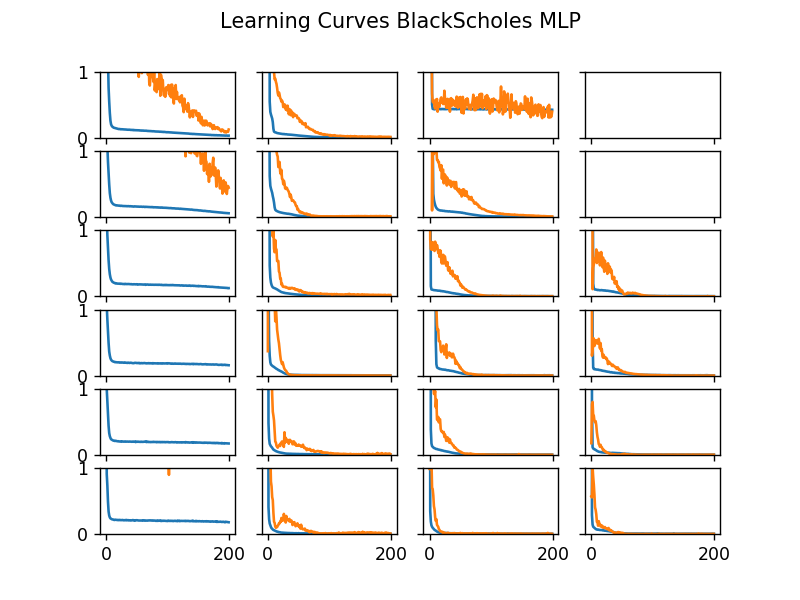

interactive(children=(RadioButtons(description='Pricing Model:', options=('BlackScholes', 'Heston'), value='Bl…

In [91]:
num_unit_ranges = len(range_units)
num_layer_ranges = len(range_layers)

fig, axes = plt.subplots(nrows=num_unit_ranges, ncols=num_layer_ranges, sharex=True, sharey=True)

@interact(pricing_model=wg.RadioButtons(options=pricing_models,
                                       value='BlackScholes',
                                       description='Pricing Model:'),
          network_type=wg.RadioButtons(options=['MLP', 'LSTM'],
                                       value='MLP',
                                       description='Network Type:'))
def plot_learning_curves(pricing_model, network_type):
    mgrid = model_grids[pricing_model][network_type]
    fig.suptitle('Learning Curves %s %s' % (pricing_model, network_type))
    for u in range(num_unit_ranges):
        for l in range(num_layer_ranges):
            axes[u][l].clear()
            axes[u][l].plot(mgrid.history[u][l]['loss'], label='MSE')
            axes[u][l].plot(mgrid.history[u][l]['val_mean_squared_error'], label='val_MSE')
            #axes[u][l].plot(history[range_units[u]][range_layers[l]].history['mean_absolute_error'], label='MAE')
            #axes[u][l].set_ylabel('Loss')
            #axes[u][l].set_xlabel('Epoch')
            #axes[u][l].legend()
            axes[u][l].set_ylim([0, 1])
    export_figure(fig, 'learning_curves_%s_%s' % (pricing_model, network_type))

In this grid the rows represent the increasing number of units and the columns the increasing number of layers. If we apply the algorithm described [here](https://github.com/niknow/machine-learning-examples/blob/master/network_topology_selection/network_topology_selection.ipynb) to chose the final candidate, i.e. if we chose a threshold of $0.1$ for bias (blue) and variance (orange) of the network, then the first row and the second column already does the trick for the MLP. There is no substantial difference in that regard between Black-Scholes and Heston.
For the LSTM, none of the models of the grid manage to learn the objective with a bias and a variance below the $0.1$ threshold. If we relax this to $1$, we manage to be below that for the last row (i.e. the maximum number of units) and the second column for both Heston and Black-Scholes model. 
Thus, as expected, the additional complexities of the LSTM ironically prevent it from fitting the prices better than the MLP. That is excel at problems where complex dependencies of long-term and short-term memory play a role, but the paths are Markovian, i.e. have no memory here. Thus, the MLP manages to learn the pricing function better as no degrees of freedom are wasted to be able to deal with an obstacle, which is not present in this pricing problem.

## Selecting & Inspecting the Final Candidates
Based on the above reasoning, we chose the final candiates.

In [92]:
model = {'BlackScholes': {
            'MLP': model_grids['BlackScholes']['MLP'][0][1],
            'LSTM': model_grids['BlackScholes']['LSTM'][5][0]},
        'Heston': {
            'MLP': model_grids['Heston']['MLP'][0][1],
            'LSTM': model_grids['Heston']['LSTM'][5][0]},         
        }

## Statistics
We evaluate the chosen models in a few standard metrics.

In [93]:
model['BlackScholes']['MLP'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_219 (Dense)            (None, 13)                39        
_________________________________________________________________
dense_220 (Dense)            (None, 13)                182       
_________________________________________________________________
dense_221 (Dense)            (None, 1)                 14        
Total params: 235
Trainable params: 235
Non-trainable params: 0
_________________________________________________________________


In [50]:
model['BlackScholes']['LSTM'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_171 (LSTM)              (None, 300, 44)           8096      
_________________________________________________________________
dense_321 (Dense)            (None, 300, 1)            45        
Total params: 8,141
Trainable params: 8,141
Non-trainable params: 0
_________________________________________________________________


In [51]:
# traning samples per parameters
df.shape[0] / model['BlackScholes']['MLP'].count_params(), df.shape[0] / model['BlackScholes']['LSTM'].count_params()

(510.63829787234044, 14.740203906154035)

In [52]:
model['BlackScholes']['MLP'].evaluate(df[['K', 'T']], df['C_BlackScholes'])

120000/120000 [==============================] - 84s 704us/step


[0.007257113837814146, 0.007257113837814146, 0.05598164164588476]

In [53]:
model['BlackScholes']['LSTM'].evaluate(data_lstm['BlackScholes'][:, :, 0][:, :, np.newaxis], data_lstm['BlackScholes'][:, :, 1][:, :, np.newaxis])

400/400 [==============================] - 16s 40ms/step


[0.6510686941444874, 0.6510684943199158, 0.447913333773613]

## Predictions
We compare the quality of predictions made by the trained model.

<IPython.core.display.Javascript object>


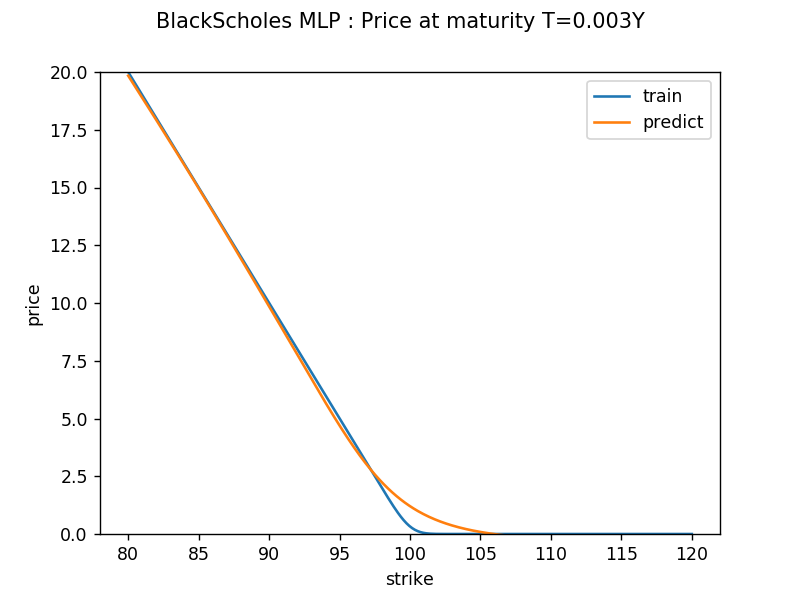

interactive(children=(RadioButtons(description='Pricing Model:', options=('BlackScholes', 'Heston'), value='Bl…

In [94]:
lstmx = {pricing_model: data_lstm[pricing_model][:, :, 0][:, :, np.newaxis] for pricing_model in pricing_models}
lstmy = {pricing_model: data_lstm[pricing_model][:, :, 1][:, :, np.newaxis] for pricing_model in pricing_models}
lstmpred = {pricing_model: model[pricing_model]['LSTM'].predict(lstmx[pricing_model]) for pricing_model in pricing_models}

fig, ax = plt.subplots()

@interact(pricing_model=wg.RadioButtons(options=pricing_models,
                                       value='BlackScholes',
                                       description='Pricing Model:'),
          network_type=wg.RadioButtons(options=['MLP', 'LSTM'],
                                       value='MLP',
                                       description='Network Type:'),
          matindex=wg.IntSlider(min=0, max=maturity_grid.shape[0]-1, value=0),)
def plot_slice(pricing_model, network_type, matindex):
    fig.suptitle(pricing_model + ' ' + network_type + ' ' + ': Price at maturity T={0:.3f}Y'.format(maturity_grid[matindex]))
    ax.clear()
    if network_type=='MLP':
        df_slice = df[df['T']==maturity_grid[matindex]]
        ax.plot(df_slice['K'], df_slice['C_'+pricing_model], label='train')
        ax.plot(df_slice['K'], model[pricing_model]['MLP'].predict(df_slice[['K', 'T']]), label='predict')
    else:
        ax.plot(lstmx[pricing_model][:, matindex, :], lstmy[pricing_model][:, matindex, :], label='train')
        ax.plot(lstmx[pricing_model][:, matindex, :], lstmpred[pricing_model][:, matindex, :], label='predict')
    ax.set_xlabel('strike')
    ax.set_ylabel('price')
    ax.legend()
    ax.set_ylim([0,20])
    export_figure(fig, 'predictions_%s_%s' % (pricing_model, network_type) )

In line with the learning curves, we find that the MLP fits the data better than the LSTM.

<IPython.core.display.Javascript object>


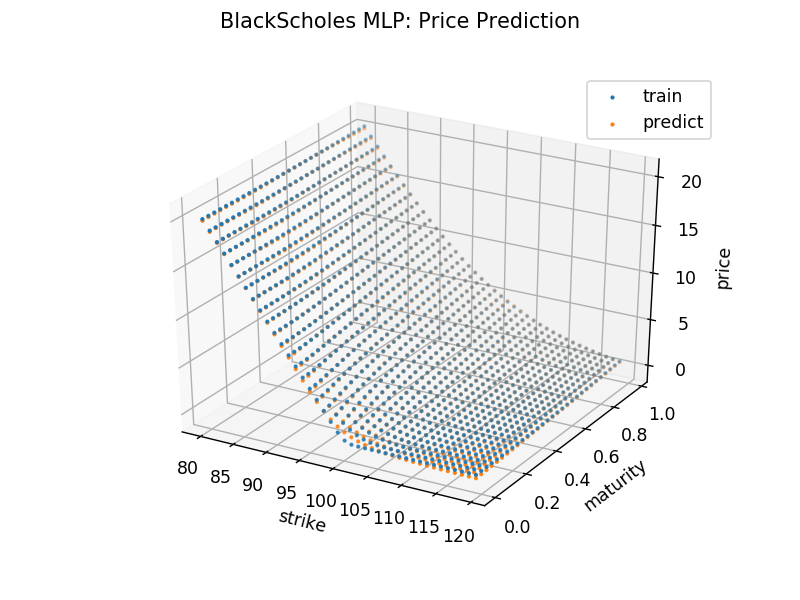

interactive(children=(RadioButtons(description='Pricing Model:', options=('BlackScholes', 'Heston'), value='Bl…

In [95]:
# 3D view of predictions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# thinning out the df to avoid performance issues in the plot
df_3dplot = df[(df['T'].isin(maturity_grid[::10])) & (df['K'].isin(strike_grid[::10]))]

@interact(pricing_model=wg.RadioButtons(options=pricing_models,
                                       value='BlackScholes',
                                       description='Pricing Model:'),
          network_type=wg.RadioButtons(options=['MLP', 'LSTM'],
                                       value='MLP',
                                       description='Network Type:'))
def plot_3d_predictions(pricing_model, network_type):
    fig.suptitle(pricing_model + ' ' + network_type + ': Price Prediction')
    ax.clear()
    if network_type=='MLP':
        ax.scatter3D(df_3dplot['K'], df_3dplot['T'], df_3dplot['C_'+pricing_model], s=2, label='train')
        ax.scatter3D(df_3dplot['K'], df_3dplot['T'], model[pricing_model]['MLP'].predict(df_3dplot[['K', 'T']]), s=2, label='predict')
    else:
        ax.scatter3D(lstmx[pricing_model][::10, ::10, :], df_3dplot['T'], lstmy[pricing_model][::10, ::10, :], s=2, label='train')
        ax.scatter3D(lstmx[pricing_model][::10, ::10, :], df_3dplot['T'], lstmpred[pricing_model][::10, ::10, :], s=2, label='predict')        
    ax.legend()
    ax.set_xlabel('strike')
    ax.set_ylabel('maturity')
    ax.set_zlabel('price')
    plt.show()

# Conclusion

* The overall champion model to learn the Black-Scholes (or Heston) pricing formula is the MLP with $n_L=3$ layers and $n_u=13$ units (equivalent to $64$ initial number of units). 
* The performance of the champion MLP on the Black-Scholes model and the Heston model is comparable.
* The LSTM is not a good network topology choice for learning the pricing formula of either of the two models.